## Тестовое задание 1 (SQL) (для кандидатов)
### Выполнил: Гусев Иван

## Описание заданий:
Дан csv файл с историей заказов (client_id - торговая точка, purchase_date - дата закупки). Надо написать SQL запросы, чтобы посчитать для каждого месяца:
1. Новые торговые точки 
2. Торговые точки, сделавшие заказ в прошлом месяце и в этом
3. Торговые точки, которые когда-то что-то заказали(только не в прошлом месяце) и вернувшиеся.
4. Торговые точки, отвалившиеся в этом месяце. 

Не обязательное задание:
положить этот csv файл в SQL базу данных


Ссылка на файл - https://docs.google.com/spreadsheets/d/17_6G4XcRHd5lEnl6Aop9WLINwvpca0-S-5Inyk1uxdY



## Выполнение:
Для начала я бы преобразовал формат даты в более удобный вид самое простое это создать новый столбец например p_date:

``` 
ALTER TABLE "Hors".orders_csv ADD p_date date NULL;

UPDATE orders_csv  SET p_date = to_date(purchase_date , 'MM DD YYYY')
WHERE client_id = client_id ;
```
Затем удалить стары столбец и переименовать новый в то же название
```
ALTER TABLE "Hors".orders_csv DROP COLUMN purchase_date;

ALTER TABLE orders_csv  RENAME p_date TO purchase_date;
```
Либо не удалять на всякий случай =)
Дальнейшее решение будет производиться с обращением к столбцу в уже удобном формате.

## 1. Новые торговые точки
```
WITH sub As
(
    SELECT   client_id, 
             MIN(purchase_date)        as FirstOrderDate,
             min(extract(YEAR FROM purchase_date))  as Yr,
             min(extract(month FROM purchase_date)) as Mnth
    FROM     orders
    GROUP BY client_id
)
SELECT   Yr,
         Mnth,
         COUNT(client_id) As cnt
FROM     sub
GROUP BY Yr, Mnth
ORDER BY Yr, Mnth
```

## 2 Торговые точки, сделавшие заказ в прошлом месяце и в этом
```
WITH sub_m AS 
(
SELECT client_id,extract(MONTH FROM purchase_date) as month , lag(extract(MONTH FROM purchase_date)) OVER (PARTITION BY client_id ORDER BY purchase_date)
FROM orders
)
SELECT  MONTH, count(DISTINCT(client_id))
FROM sub_m
WHERE MONTH - LAG =  1 
GROUP BY 1
```

## 3 Торговые точки, которые когда-то что-то заказали(только не в прошлом месяце) и вернувшиеся.
```
WITH num_month AS (
             SELECT *,
                    EXTRACT (MONTH FROM  purchase_date) AS month_trans,
                    LAG (EXTRACT (MONTH FROM  purchase_date), 1)  OVER (PARTITION BY client_id ORDER BY purchase_date) AS month_lag
             FROM orders 
                  )
SELECT month_trans,
       COUNT (DISTINCT client_id)      
FROM num_month
WHERE month_lag IS NOT NULL AND month_trans - month_lag > 1
GROUP BY month_trans
```

## 4 Торговые точки, отвалившиеся в этом месяце.
```
WITH sub_m AS 
(
SELECT client_id,extract(MONTH FROM purchase_date) as month , lead(extract(MONTH FROM purchase_date),1) OVER (PARTITION BY client_id ORDER BY extract(MONTH FROM purchase_date) )
FROM orders
)
SELECT   MONTH+1 AS n_month , count(distinct(client_id))
FROM sub_m
WHERE lead is null or month +1 < lead
GROUP BY n_month
```

Данные запросы работают для данной выборки данных но необходимо будет скорректировать если данные будут за весь год или за несколько лет

## Не обязательное задание: положить этот csv файл в SQL базу данных


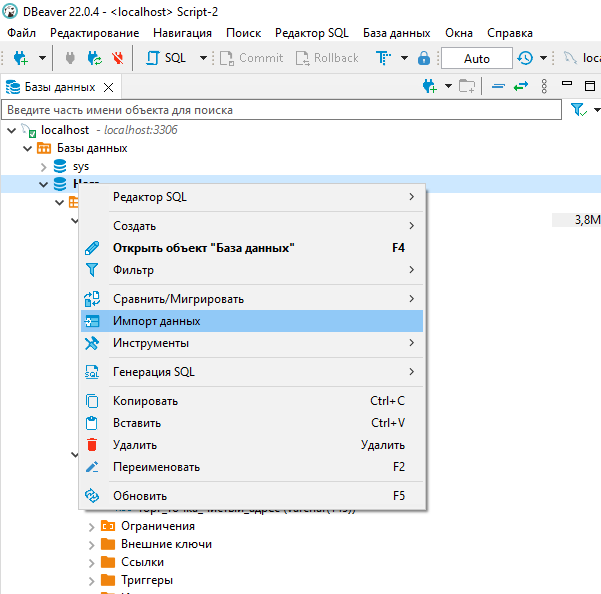

In [5]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAlkAAAJSCAYAAADwP9CEAAAAAXNSR0IArs4c6QAAIABJREFUeF7snQmYFNW9t389GwMzDAMiO4IyI7KooI4o4IqiLCoSJJJFMOYOUXJh1PAZPiBeEwwSYwQDGrh6HZJ8miCXgLIohgQXUERFZWcYFkdWAWHYZ+vvOdVV1VXVVV1LL9Pd8+vn8ZHpPut7TlW9/T+nqn1+v98PvkiABEiABEiABEiABKJKwEfJiipPFkYCJEACJEACJEACEgFKFicCCZAACZAACZAACcSAgKVkbT72HdYfPor1h4/g27PnpKo7N81F57xcjOjSGa0aZ8egOSySBEiABEiABEiABFKDQIhkna6uwcJde7BszzdhezikcweMuKQzcjIzUoMEe0ECJEACJEACJEACUSSgkywhWE+t/wJ7Tp5CTkYGBnfqgO4t8tGjRb5UpXh/+Z5vsHr/QTWy9WRRL4pWFAeERZEACZAACZAACaQGAZ1kzd++U4pgiaVAIU8XNs7GO28tQVpaGupq69DnxpuQn58vLR8KGTt89hxERGt014LUoMFekAAJkAAJkAAJkECUCKiSJcRp3PsfS8XOufE6SbD+9udX0a59B7RoeSF6XtlL+mzH1s1ivzyad74EE9d+ijM1NZKQKdEufbtWYKxvMOZp3uw7swxrJihSFvp58XI/5g6KUu8iKGbFWB8Gyw3XttnqfV1VK8bCJ2fW9ze0QTtn9UPhgpEoWzMB0VVVwXYaupetgYo7Ah7BrNpyY1WHh4ZqmAPFWO6fC8fTaOcs9CtcgJFRYuVojnjoIrOQAAmQAAkkFwFVsl7ctA2r9x3Eze3aoPOurTh54jhuHHA7Pv9kHY4dPYIfPVSM0d+7Czu2bsVV1/TBi395DW/s3IM3yvdg0EXt8WC3QpOeGy/CslQVL4dfMinD59LFbgumuLlAxoL3zlmYVTYBE6SrtKaNsHhfZ0ci/WIMk/pgJyEyj74zKVm2rMIMtHHe6MYvmhPEbjwBWM2d6Bp0NDvFskiABEiABGJEQJUsEZXae/IUHuvUBiX3DsHU3/4OQ+79nq7a91b9Ewv+/D+Y8tvfoW37Dth87Li0bCiiXiL6FfoyuSjpLohmEhaL6Esk9HZiVr/RwHxjRMjifRFRWTxMlkhxze2H0Zivid4F2yI+exYjsWmBKD7ySNaKsf2wY6LSTgdC4AlLrCJZxvYKvs/i0jUOIlKC+bTuMRBVIyC3TK3mjifwzEQCJEACJJBkBFTJGvnOaqnpC+64GQ//eBRe+svrll05ebISpypPom379tDmcyRZEBeeQmyZIpYFDRctg6CIqEC/whKslQoOLgFpl2MgRcUKNWXKrdBeeE3LCdSNYmDevJ5hlpe0kSltD83fD5EqY5+UIkSbnr0UaybuQMDhIpAsealMv9RqFiVUWAL6tIExKQmAVj8L5WyMPsp1LB+JBYMDZeuWR3XctXUa61sODNYsK+sinYMxT/3bakoGIoKbdEvRKmiTvhnHfhgWq0urVn0q0y9927ZJ1G81d5LsLMHmkgAJkAAJeCJgKllvLXoDdw2/TyrwwDffAD6fJFTita+iAv/z0mx8/4ExuPSyblGQLO2eLe1emlAB67djoiEipElTpo8gCUFYPMxc5ALlBC6a5hfmIEtRzrTu2n1kgc+s3ncmWZoIB2Z5lyxFYkwv+MaI02BA2e+m24MUEJ4FI0P7qKGg2d8VWu48ZblTkj1RjbJUalGnYaxkotZ7yEwl0jjfg+IWFEirvhmlLEyfdKzcRbKs5oinI5WZSIAESIAEko6AKlli07vY/D62XUvsfm8VfvrzCVJnTlaewB3XF2HQPcPQ+5prsea91Thx/BhenP+a9EiH/7P2U+kBpb+7/hqTzptdlLRLKGbRFnkDspAPNYolF63IhG6Tc1/MlDYsG/ZC9duBiSI6ZIimSCVJ5cBmY7jVBTq8lDiRLF0a0T6zSJZFFE8LORBpUvpvxK/fS2bc66ZKaGGYfXCWnJUl3TDLvdL46ffX6essAUJugrBaKlYEysGGdplbTyGUln0Lt0wdOmcthd1yjJyIa9KdK9hgEiABEiABlwRUyXp1WxlW7N2HVnvKMHvsf6jF7P+mAt8beDPEz0j/9OcluH3wUGz64nNpv5a6Wb59GzzS8zJnkhV2T5ZmKdHqAqnLr9/zosjLfIwO7oOy3EwfLirhch+W3nxs9mQFoijaOy6l7J43v1sJSISSZck53J4sh3XKt/1Jd1aWrJWXJ62EXCxjWomk+WyXyt0yBX6xFGt6I4UbyQqzvG1aPfdhuTwHMTkJkAAJpCwBVbKUTeziIaS/63uNtJldvF6Y8Vu8VvqK9G+x2f1UZSXmL3oTmRdcqD7yYfaN11n8zI7ZxUyzhGR6d6FyK73FPpuQvVaaW++lqNAW9AQwTN0wbbVfJ4xkWe2jsnrfcAdi8MIeTkjkOWUVyXI95ezEwbh0p0SZLKIulpwdSpYUWbSqM9i5YFRPLN9qI1kuZGXFLMwqnCA/qkLbH1gshdqzUpeRw34pMPteoV+2dj2MzEACJEACJJAyBHQPI1WiWUKwpIeRZjfC8NtuwoH9+3Qd/sGEx7G9+1XS8uKgizrgwW5W96cbozbGiITN58alPs0md2mTdt9iFGMTuqt3/slRnZ7KIyI0IqNderRZLlQiLNpOiw3dIkImIi/G9wP7uzSCoFlmC+4PspC6qEmWcU6aLcUqG9/Dj0OgzZrN6TrOTiUr8DiD4JKvpk6LZ1qpG+0dbSrXhQ/DbErXz7FA3+wkS7khQr7lQvPsNrs2Ws2d4LPhUubcwY6QAAmQAAnYELD8WR2Rr1u6H/965ilU76uQimlUcBmyC7qi6U23Ia1xE+kHo/mzOpxjqUXA3eb21Oo7e0MCJEACJBBNAqY/EL2gfLe0PyvcS0SwRhbwB6KjORgsKxEIULISYRTYBhIgARJIBQIhkqV0SiwFLti5G3tOnpYeUipeYhnxmgsvwLWtL7T4GZ1UQMI+NGwClKyGPf7sPQmQAAlEj4ClZEWvCpZEAiRAAiRAAiRAAg2PACWr4Y05e0wCJEACJEACJBAHApSsOEBmFSRAAiRAAiRAAg2PACWr4Y05e0wCJEACJEACJBAHApSsOEBmFSRAAiRAAiRAAg2PACWr4Y05e0wCJEACJEACJBAHApSsOEBmFSRAAiRAAiRAAg2PACWr4Y05e0wCJEACJEACJBAHApSsOEBmFSRAAiRAAiRAAg2PgAvJEk/C/g26la1FidXvQRv57ZyJvg8Af15bggLtv2PC2fhj09fjeTdtjUmbWGiAgNXc8TCnUhapcf5qO5osczlFj0GLHzQXI7RzZl8UPvpRcLB0P24e7fltMkdc/5h6yh5A7jumG1fg+ufLsNbxxc19dd5z7MTMvoVQp9n1z6NMXFO9F8iccSTgQLIMAyw1rhjL/XMxyEFDtSeh4uV+zHWSyUG5oUn0JzSp3gUjORk9sYx2JkqWPdFUYJSCx6D4cli4FVOV893OmZhZVoKSQYpgXa47F64Y68NgLIdfOtHFQrJcftG1n3gNM4UkWBs1X8QD17kFIxNMtKT59ygu1147NXOwYQ5ecvXaRrK0E68sGMkqExMUjkUrPkiMJ7Ron+Di04vUrCUVBCLWI5MKjFLwGBQX4990C/2yZpQvdXqIc6YUvkdJQbTPQdEuL9ZzOlHLD1zXtk41fOm3HNP66odFO+urOazXE4HwkqWbdPoDXHxj+023gPVL397myfWr4WuTb7WPIuSbQzDSHumSiM0JXv5GEAjsayNx2hB8sA32fZLzFT+P5zc+GgzlquUPw2LN8mogoqf0X27r8pFYMPhRiDbpQtW6tgLBCKBhuUATNrZvr2iYlpHN+Fjy8jLPnAmEdR8GQ5leUPscrv3mnMoczFM3jHTtRbTnr8LZwC7s3AhGOfTzTZSlj0gH5pRxPgzGvIiWnxLtGJyLQXa8rI5BdZoH5tJG41KSkK/Fw+SIlf6YCJ4bNV9Mo7K2E16yzI4f/XJm8LxnfqwZj22v58bw55pwx1iwBUpf/ww8oIkwWUmvm9OSa0FWzvUiQgnDtpnQ62LotdBN4zRpbaXPcJ6TsirnofDXGO/nWi2LQRbXfo/9TdFs4SVLN6GtJSv0wDB+i1uBsX1/g40fASPVfVLR/sZnctFVlwsNJ6cVY9F3+0R5/V20bTsmru2KZ033nJmJSeDA138TCneBMfZfnqiKMEgH0wKZTeAzKOHhkM+UC6lItxjDQpZtrUXK+uRm1j7NsoSOl5cjwexkoJRjJidWfdD22ZBGN7/CX4zCn+TD1K2tA9plJLv6nDBzIqIu5oaOh9VSiP5CFvLN3kmzdWkS8RgMdywNxjzTY9DY8aCgKl94JHnZOtVUssRnD+DPWFsSC8nSfOEwfjnTiaFxWVF7vtX2L9zc9XJuVPbsejkPWbVLOe7FF1ezc57LiWq5P1gbObI6NsKd551yddhe233MNtccn5P57eZca3bds/gy6LCLDSGZx0iWIYyp20BoMOmytej6rA+Lhy0HBmsPfKsLplfsxgu5Jlpl+DYr1aB8Y1e/kRq+oYTp08brJVs0bJK0nvCh/Q89sYlvFouH+TG30LAHRMSflM+kyEPwJKvb42bZXv1JOeSbjtn4SAIRiLCpr6hGOCwOTAd90Ef1AvPJCV+pRpt5Gtjzan7SCamjPiRLV2eAoX5uWPAwySfnlr6Vm89nL8dhgh2DJpEAM17KXufgZxZ91+6PgXUkK7aSZTyH6r8M+dQwSmhU3v58Yei363NjuHON889Co6zBYzcq+3pdRLJCjw2zL4yaL4qm5xgvx5J0V4V+P2BIMXaSpRdt3fz2cK41PU9Es78eMSV6NtuN76ahb+2eLN1EMIlOiXD84q5YawyzhomSeYMW5htZmMlqetLVXZSMfRqMjddfj48uN36LtZjwpv03ptVIq61kKQeOpl1h22t1UpbbYNY+y4uyt5FxdHehoz44nV8mc8FunqoRVhPJspjD+qWYOCwXOpEsV+MZuGCYz2cvY51gx6AryXK2/0WNYE3cbnEBjHaEPlx0xOq8YR61Us/lQ5dq2m4V4TIX+BJHx6n1l5VwX2Skz9TrgmFlQb6YR0Wy5KXz8HuyrI6NMGJjycbLsSTy2M1JN5LlZK5oy3Nw3bM8p3rtb2rms5Us416OAAZNlEgrSybLXvOMa8TyxUy7pys6d+HYhL3N9lVIUQsl/KzJLyRS2exqsVwnIhvKnjRtVCD4iAvlG09oZC+wIVazzyNk75txiUO5u8l4EMhLluJbtU17zU9u4tulg/ZFPPetxsYd85ICYzg/XPsNyyVh52k4EbWqw+KmEM97bxwwkueNfilZOzectFXbwGCdofPZy6An5jEYjpe618rqi9iKmZhZWCI/tka/7Crta9movZ1eXla8PE53F2rPTZbnrOA4qufcrs9anC+MQuft3GgrUmH2hppLlnKejtJyoRrV1t68ZTgna9qoPzbCiI2DMXB9VJnJpXp3oZ1kWVxjHJ0LzZZOA6sG6nXPshzXvUzpDA4kS+m/1QlUs6H2+mIUYyO6qXfWaDeMKvkD67qPQntyCndydsrfpgzjkmFxMYrnzQtuqFarEQI5EduV55KE9EkbSdL2w2zCm/U/uF8NxcC8efJWfMMtusHlOm2ERBE3ubHqEl64MQgvEMENvYb2h/BSLhxOxyPcN3CzORV+Hqkb33U3VoTnq3+mm8PydfNAnNTN6xAnm+AFNpbzN9y4hM4Ny/GULhrGpeZQaRfHpX9tiZdBtn9kQdyPQWXJRVn6NvL6jfi+aH4MqgSsjrlAgpDnZOlugDDktdxD5RR3aHnByI75/JbmqXLwqDeNWB0L2uPSuLynfLl2cm6ULEazQdxeBtTjO+RLn37je1QfzWN4TpY+SmZ+bJSF7N01SSfdyaS9FjodX4t0xuPG4uYfM+bm89vhudD0JjY5r3T9HoqlptfJCPubYtldSFaK9VwXxdKeXKKwsdIWVTQuyraVMIFnAso3Z2fPgvNcTYPPaMY5XuxjdAyqF8RIl4/rc3LU57jUZ79Tqe4Yze9UQhSnvlCydHfnJfkJPk6TJvWridc8SH2S4XtYnxdzXoSsx6Y+x6WhHxPR6j/nd7RIRlpOA5asSNFFkp8HQCT0mJcEIifAYzByhiwhcQlwfifK2FCyEmUk2A4SIAESIAESIIGUIuCrrKz0p1SP2BkSIAESIAESIAESSAACvuPHj1OyEmAg2AQSIAESIAESIIHUIkDJSq3xZG9IgARIgARIgAQShAAlK0EGgs0gARIgARIgARJILQIpJ1mzZ8/Go48+iurq6tQaqTj1hvziBJrVkAAJkAAJpDwBSlbKD7G7DlKy3PFiahIgARIgARKwIkDJ4tzQEaBkcUKQAAmkEoF3V32QSt2Jel9uH3BD1MtkgUEClCzOBkoW5wAJkEDKEhCSNWL40JTtXyQdW7hoKShZkRC0z0vJsmfUoFIwktWghpudJYGUJ0DJsh5iSlbspz8lK/aMk6qGaEjW4bM1OFcbvtvpaT40b5SGJum+pOLDxsaPgN/vh8/H+RE/4qlZEyWrYUpWnT/wCNC0ej6HSJK1f/cWHDt2FD2vdr82m//qbqkjxx+8WB1J8V7LxhnYeX/HuB+10ZCEaDc60RiF6180+Cn9teMo5sz241Xomp9llzRpPrc7lv75z3+ipqYG6enppn06c+YMGjVqhBtuuAE5OTlJ0+9YNXTJkiVo3LixafF1dXU4d+4c2rRpg6KiIkumsWpbMpQrHYviIiNfcCzb7PPh+JjOCdGlgyer8bsPDqP82HmpPf0uysUDvZujTdNMR+0zHoOUrMgl69Nvz+OVbZX48OB5HDpbi2ZZaejVMgsju+TgexfnIs3RyLhPZHc+NZa4oXw/zpyvxtUF7ZGdlSF9LKlWPX5hkyRr42cf4NixI7jp9ntdU0g0gYhEEhYvXoy8vDzceuutEgfxt3gNGjRIuvB5fcWLUdas3yB9yV9x9l/bpaZmvPk6MmdPw9mVmx03PRJ+ohLR1xvaZmN6n5bov/gb23q1cm6bOAkS2B1LYk4NGzbMsifKnMvOzqZoycegE14ULfMp1erPe1FVZ/hRD79f+nafkRaMEoo0iSJZP1ywB30vysHoqy6QOrVo83G8U1aJucMuQm6W/eXceAxSsrxLVnWdH7/85Bhe2VqJ3EwfbmrXGB1zMnC8qg4fHDiLfadrUdQqG3+5tRXaNDb/4hjJadvufKotW8jV6q924eI2zVG27wia5WQjP7cxrry4rZRMRLbqI6oV8XKhlUDkN0rH1u93ROM4LwdFIgnxlqxoMGpy55U48/aX0iRqNHsa0hb9pd4lq+SKZvivq1uYHltivlzWPBN3XZSDyVc1tz7+3i1B/n2l8udj8Mbxmbhd/mvXSwNx1aRPgnnHvIHjM5VP30VJ/rPo+vlKPHxJJId3bPI6lSxRuxCt2267DRkZgW9k4V6KnIk04aTErpxofG7XRzd12JWl7Xfbtm3Rp08fW4FVEjjlpG2D1b/d9MksrV0/Iy1fyZ9fukf6Vp+oX27W7D2Nt8tO4De3tdN1+bHl+3BHYVPcUZjnGgUlyxqZ3Z6s4g+OYMHOk/iP7s0w9ap85GUGJbcOwF93nMQT646iXU4mVg1ti3wHEux6AF1k2LjnIFo0bYJWzXKw72glDh8/hf3HKjHomq5olJnhUrSicy2JSLLsloXEkuHKIW1wicMwrwuWlkm9StZ3332H9957D5mZmRgyZIhUvnICv+yyyyD+8/Ka9MkxvLT5hGXWSBllvj4XmfNflETL990RZH+vnypZWY8+gIyvPkFVyX+h5q77HTXfKz/1JP7qbthJ1vcuycUrN11o3Z5dL2HgVdsxURGrXS/hpfKH8fDtQECwuuuk692SfNwHRbSic2A4guUhkd3FVCsNovg777xTki07wdIKg10dHprtOUukbbHLr+UlOAleVi9jWXZlK+WkqmRphUv6t9j2MaazFI0WS4z1Edmav+GY1I7RvfVf0qzedzIx4yVZK8b6MBjL4Z87yEmzEiJNOMlatPs0frL6MH7Rqzmm9M6X2isiW7tPVuPSZsEtHh8cPId73zmI73fJxZz+Leu1XyJa9d7GXejT9SKcPleFC5vlSJIl3rv3+p7SEqLzvZ7RuZZ43pMlDsRGGWk4XyN8Nvwrnt+avErC22+/Le3vsHr16tULnTu737PQ+i97bRk9eXVzPHpFYBJ7eelE6/hRZD32ANL27NQVVfX0XNRef7Nt8V75KQWLeRGxZIko1rNd8fnKh6ELRhnlS+3NLrw08GfAn0T0KjoHhi0oiwR2ewicXtj/9a9/obKy0laynJbntT+R5ou0fW7yi2OYkhV+xCzFSitZmn9HOv5u80dDsuplT9bOWeg3egt6YhO6z1+DCQVOer4CY33T0L3MaXonZbpLE06y+i/Zj/N1dfh4WAcoC1J7T9Xgyjcq8O3ozsjULDf/4uNj+J9tldjzw4t00S53rQlNbXc+1eaoratDeloaPtu5D+1a5KFti6aoqqlFVkY69h+txNqtezGi/+UumhSda4nnPVl2UazsjDSckwXMq2Rdd911lkA+/vhj08+8SoIxgmAs3Gs0KxwnweiKCxphfM883NmhETLSvK9pN77jCulOLCmideIYRBQrbU+Z2o2aX85A9UDrvUBKQq/8oipZEJP7PmyZ/jlWatf8hHwtG6JZGgyOkohmPdtVpC+P6nKh2zlot4fAqTREU7KslhKVtiifK9Ew49+CciRplVFyujynPfac8hJ5IpUsO05aDuGYKJ9Z9dusnlgtQxrPY7FYLnR7jFid1IVgif1Xp6rMv7iL/Vh3FOThkevCR0vqY0/Wzln9MBrzMR+jpf+vcWRZiStZB87Wotvfvsavrm6OxzQBACvJ+vJoFW56cx/u75KLP91ovUrhdq7YnU+1c0mJUJ05X4WPt1Xg1iu7SB/X1NYhIz0NqzfuQn5OY/S6pC0UIQtvXAbJkr7kT4KyUWXMG8eh7lKB+KJ/FZRdLMpn4rrkebkwnDwM6dQEf+x3IVo0st+kaKeVZoNiJViiLK+SEG/J0jKqqqvGllN7cfPH41B+yxu4INP9vgMhWag+D19WdkC0Kr9Do8fHwFe+LTDRkkqyRIuDk1aZsNJS4faJppIlPvsZ/hR1yRItcTsHw81pp9IQLckKt0RmJ1fGC7/ol5WIxWpJzSkvp5KlHZtwS6xO+mPGz0wknQiUVmK9yKjdeVT9EqTZk6UsEe79wUXS3WKRvCI9RuasOyIJlpPXA71bhCwnhssX++XCnZjVbzQgIlgQES3xzwkIBLOMIqX8PQVbCgdjntLwYnmZUUTECkuwVn6/eLkfsVx9NItkHT1fi08Pn8f3/3kIc2+8ELd1aIwLGgUCAFaSJW6caDVfXnLWPGnAbFwinStWY61IVuWZc9j+zREUXdpBWhoULxGAOHX2PN75vAzf69cTdXV+pGkiceZlaiUr8MUfilhJwvUP3Cvt/Q1cq/5xryEoIBcadcnq3zYbS+8M7OYXr/yVd+D4wHecHDuWabSDEk6wRAHJIFlaRt3f/yH2nzui6/vR21cg3efupKdIljShtKL1iwfh27k1CSVLRiJ/e+guJjesI1mxlCzREjdzMNxkdyoNmzZtkk4QXbt2RVaW9SMu7MqzkywvoiH657Rcu/bZnRjc5LdLG052vPQnXB6FkdI/rZxaiZhIG0vBks7HJpJ1ZHRnZEThcWSRHCP3/HWXZQTLOEdERGvJj5zf1RJzyZKWChWx0giXZFlWkiWWCM0+GwwoYiUJ1wKMjOFyoplkaQMoQk7EeUhZjRKPb7jqf7/B6eo6lP/gIlW+ztb60fbPe2wjWcpYRjJX7CTrmyMnpP1YbZo3ReNGmdJyoRK5endDGTq3bo7Cdi2l99J8adITTmwlC4Z9wgBElGrZkOOY2SX0M7W8d0sCkSw3657axphFs9YM64AezYPPM4mGZCkXOTvBikSyxPN4FOs1A96tWzfpguf2FY6RYPPyFZNwSeO22H32IB766rd47/oXUdCkA3LS3T0yovGIG4Bjh9XmBUXrBBr9YgyqHypBbZ+bbJvvVVKVgqOyJ8vQSjWCNX6nfkO8mi4+e7LEicFuDtodS3YiYDtAhgR25TmVBzfi5CatXfvs+htpfm35Xlk4iWoZmTjNo7TPGBWz4+L1c7Plwu+q6tA8wkiW9uJpd4yYtX3A/+j3kIo0/29kJynpDxfsDcmy6ifWm57ivSdLWSpUlgjF34Vbpsgb4F1IliRVWzDFPxfK1nmxmX7xsNhFs6z2ZGmvW8btPspSorg7fmbfCzCscw7WHDqPIcv3O5Ysp9d0u/OpdmKImJXwpaMnz2DPoe/wWdk+9O3eCT07tVaXDEWU661129C3+0W4uHXg5golX+i81ESyvEiWvIfY854s0aCStUdRur1SbVteVhq+/mHgwFAvulGIZLk5oXiVhH379uHTTz81Fa0LLrgAffv29fSwQytGRvk8UXNamiB5Gd4eQJm+cxsyJ46G70Qw5K6KVlUV/GGiIVq+Xvmp4x2Vje8v4aUuD8uPYNCHYqU7CbdM12yKl5cVuyfG3YV2ewiiKQ3aC7RVRMqrWISThkSRLPEw0jfffBN33XWXhEJ8605Ls44Ae2XhVJicpLMa//pcLjz0405oFOdH7RjP6aaSdZ8sWW+4k6z47skSEqVZ9lM7Vozlkiwlp2SJbgjRCrefWhErkWb06sN45+sz2POjzsh2twgT9vJudz41ZlaWDP/1ZTlOnj0vbYC/vHMb6a5C5TlZ4v0d+45Iz+e9qks7adlQ/Ds0omW3XKjcAW+xXCjfwOV5uVB0TmxPHPv+t3ij/JTaVwFcCITVK9KlQzvhikQSvvnmG3z22Wc60WrevDn69evn6FlFZm0zMrrigiy8f3d7NWllzekQsYok+pfUXp9AAAAgAElEQVR9bx9T0bLjpnweCT9RxukaP8SjVLIs1rvFgWv7CAd547vylCzonoOlPMZB85wsXIvp6nOxAmvnal4A1xo30DuFEYN0TiRLiWpoq7dbRtLmMaa1+szJcpfVMpdbYRF9seuDGe5wvMRn4sn5tbX633C65557TH+Ox6wsoxgpbXAircZxcsPdWE+4pcxoTkOz5cKKH3ZC08worBdG0FAzyRJ7r8Trz/JjHbTFh4tkGZsR0+XCFWPhm9YdZeoeLFG7WDIsxJYpIgKl/bdYPRwL3+BNmCktATpZLtRHtiJAbJrV7jlZItOx83XSnj0rD/9L2Sn854ff4vFe+ZjaO8yzD6PdeJPyFMlS/n++uhYieiUe5SA5i/xAUrGcuGbrXlTX1GFIUVeLaFa4je/aa44oWX/dCewjDshXRJIliq7xA6P/fQjL9p6ROmE030iEwcuYRCoJX331FXbt2qVWPXjw4LB7Ypy0UcvoypZZeO+uoGQJPgduews1/ho0TW8iCepHfeehW64+IuikHiVN41vlZc2cPJx9az20Dyy1K8cLv3O1fmSH+SYsDlLlJghnkmXXSsPn6l0fxonvspw4JHcqWcqzscQjCcRdc3fccUeD/B0/O152n8dhSJOqCu3zsJSGV1bXRfW2ey9AzPZk3du9GdLgw/9u0W+IT6Q9WWI5b1r3spC7CXVLhpJYyVvci4tRPG+T+tgG6dla4iPTje99ZRnzQtRZHjvJOlntx61L90lPc59xXUt0zw9uBRIb5H//5Qn8aUsl+rbOxuI7Wuse6+CsBdFPZfYcLOU9RbL+d80maQlRPNJB/I6u82dnuW9vRHuylOrWHT6PO5btTwnJEp3QfkO9++67wy5BuEEuBEORrMNVx3Hp6u/rsjdKz8KhAW+5KdI0bVCymuHsW4GIj1PR8iJZ4iR90V9DQ/pK4/6zZzM8VdQCq745i/vePYjRl+ZhVr/AT2ak2stuD4ETKTCmoWTZP3pEmUdO+KbanPPaH0W4vn2gU71fHMXjG8wiVmZ9G969GcZdZ/2YgHjvyfLKPxHy2UmWaOPL2yrx5KffSZvdxevm9k2wet8Z6WeZav3ADwpy8VzfllFdJlTY2J1PrRgG91f7dMuAWpn6aOvXSE/34dpLY/sbyxHtyUpVyYrV5NdKllJHvCN9dn3zIlk1fj8yfL7Ak6ItXpnpPlTX+qVozHcJ8kO0diy8fG63h+CDDz7A0aNHQ4oWv40polViTxElK4jnrbfeClkOVD4Vy3PiAcJCQo0vL0uTXsY7mfMokrX7BxdFbeN7JDzmfPwt3tl5EqctnpOVk5WGET3yoSwjWtUV3z1ZkfS4/vM6kSzRyhPVfry//yw2f1eFZzZ8JzV8zo0Xon/rbHTKtf/ZL689tTufeilXK1rHT5+TZDG3sbsbzdzUG/FyoZvK4pHWiyTEo11WdRytqsQFWe6fixWrNnvld+x8LVrIz1KJVdsaSrlCsrQ/SF5TU4OhQ4c2yOVCJ2Ou3ZMlpIyC5YQaIB4gWV5ZjaGdmljuoXRWUmKniumerMTuum3rnEqWbUFJmKC2zi8tFYpXzJcLk5CPZZO9SkIqMYikL+QXCT3mJQESSDQClCzrEWnIkhWvecpIVrxIJ0k9lKwkGSg2kwRIwBEBShYly9FEiVEiSlaMwCZrsZSsZB05tpsESMCMgJAsvqwJ3D7gBuKJIQFKVgzhJmPRlKxkHDW2mQRIgARIIBEJULIScVTqsU2UrHqEz6pJgARIgARSikDKSVZKjQ47QwIkQAIkQAIkkLQEKFlJO3RsOAmQAAmQAAmQQCIT8O3YsUP8CDVfJEACJEACJEACJEACUSQgSVZhYWEUi2RRiUagrKwMbdq0SbRmsT0kQAIkQAIkkNIEKFkpPbyBzlGyGsAgs4skQAIkQAIJR4CSlXBDEv0GUbKiz5QlkgAJkAAJkIAdAUqWHaEU+JySlQKDyC6QAAmkJIE//vGPePTRRyF+o5Sv1CNAyUq9MQ3pESWrAQwyu0gCJJCUBChZSTlsjhsdVrJq6vw4dLYGx8/VobrOj8w0H5o18qFNk0xkyL9e7bgmJqw3ApSsekPPikmABCIkkPdKuVRC5UNd1JLEey0bZ2DXDzpFWLq77EuWLEFtbW1IprvvvhsZGRnuCpNTN0TJOnbsGP7whz/gzJkzuOGGG3Dvvfd6YpcMmSwla8Zn3+K3nxxE5fnQCZXXKF1631/SKxn62ODbSMlq8FOAAEggaQkkimQtWrQoLMPhw4d7YtwQJWvKlCmYPHkyWrVqhenTp+PWW29F9+7dPfFL9EymknX4TA1az9vkqO0ULUeY6jURJate8bNyEiCBCAhYSVZ+o3RsH9UJjdN9EZTuPKudZIUrKZyAJZNkiRWtC17dpYsqOicYTDl16lTMnDlTemPt2rUoLy/HsGHDvBQl5cnLy3OUt7Ky0lE6baJIyzaXrLM1aD3XWrK2je6GNjkZaJaV7qzBqyfCd8vvNWl/gX/7n8XNznIzVYQEKFkRAmR2EiCBeiGgCJZV5WLJ8J93tcMlTTNj3j4hWV5FYPHixbASrWSULAFbu3zrFv6LL76Idu3aoXfv3njmmWfw9NNPo0WLFm6LUdMLEbITKCdpzBrgJF+4NJbLhdPXH4L472RVHbIz0vD6oE7o2DQLV7dqDN/ML+Dz+eD3+yGWDntf2ASjLsvHT7q3kPZthbyEZC0bAv+z1Cq3s0jhbJXP7nORj5LlljrTkwAJ1DcBIViNMtJwvqbOtimRXPBtC5cTJJJkVdU6/6GWLI+RPjvBjVS0Vq9ejf3792PAgAFo3bq102EwTRepCIWrPCaRLFHhm7sqMbhzUxyT92R9eugM7lqyG3V+68G9oUMu3h9RQMmKaLqEZrYSKSeCRcmK8mCwOBIggbgQsLvIiy//52QBcyNZ1157rWX7P/nkE8vPEkmybnl5h+Mx+PdPL3WctuLct+iYfaGUXvAX1xjtSwRWtK9vx1yCRh4k7uDBg9LGd/HYil69euGBBx5w3EazhJGKkJ1kRRIls4xkiWjVdW1zMPjipvjZ5S0x9aODmPvVEVsQVeOvDI1mhYtk6ZYS78TLe1bgoU578cqgzvjp23J1d76MPSseAl4ZhJ/hT1jxkPaOktWY6FuGIVbLj9ry5XI6mdYJ7DWUr/3bzWeBVmvbJf49A5dJfQvU03nbE64ie0ahcipYimRF+k3BduCZgARIgAQ8EjBezJWLvFVxQzvnYHb/VmjRKM1TjWaiFU6wRCWJIFnijv90ebVIqz9a9RHvK3/f+vIOOJWsNw9/iB99/hQq73zXkqmyJ0sk+PrHFyM/yxv/X/7yl9KGdyFHs2bNwtVXX40rr7zS01jGOlOkUTJLyRq/eh9e+uoIxKC+f18hRMB24KJyVNVah27v6tIMb951cWifne7JMpUxIVw/A/60Arf9071kqXJ02z8RKOYh6G761dTpRqTCCVioZAnnkpdMf15u3g4HM0URKzeCRclyAJZJSIAEEo5As//ZZdqm/m2zsWxQO/WzZu8MxIk7Vrpuf58+fdQ869ats83/j3/8w/GeLK00iuiP2JNl9ZgCN3uybn2lDEKisjN8OFsTfslw8Y8uQW5WOpw8bemtb9dIgiVeO27+ewiL5pm5yErLlB7l1LJ0N/b+qLNnwRKFi43vQq7Ea82aNdi9ezfEYzAS8dWsWTOcOHEibNPCpbGUrHUHz6BdbiY65mZiT2UV9p6sRoemmfjvjUcwY/1htM3JQnVdHY6crcH9XZvjvsJ89G7VWEof8gwtgzzpIznmUatOUN5XoltyBEgNbwF3vrwHKx7aHTaStXqiD8uG+PHsxa9o5MY6UtZZU76gGqijUyD65PAzq3aJttzy+2B/vEwot4JFyfJCmXlIgAQSgYCZaK29tyN6NA9udPcqWaJ/QrScCJZI60SytHJVV1eHtDT7SI9byXI6Lksf6IImmfb1rzu+BQPXldgWK0RWhFgqq+oiEixRUWlpqVSf2Pg+d+5cafO70yU/24ZGOUHMJCt91pe4u0se/jH0YpyoqkX+ixulpn/2g664qlVjXTeOnKvB37cfx6/XHULFT7sjy6jOxgjVXkV4bsM/B3XGtif8kPbEq+9ro00BIRJpfl6ujWQpy3FDsMxyuVCzZOegTuNypLflQut2BUQN8pKo+5nASJZ7ZsxBAiSQvAQmrDmC0u3B2+7zstJQ8aPOug5FIlluyNhJlnHJU6R38pBNN5Llpr1O01b7a9Fy5SDb5F6iheEK3bBhAw4cOIB+/fpBiEyivmImWfct34OFO45L/RbLhUKkhr+1W/pb3FHYqWkmNh45h4vyslBxslq601C8TJ+bZRnJQuhepYUjpP1Xul1XcjTKrWTplv9UyeqC2cb9UXKdMZWsCJcLuScrUQ9BtosESCBWBETkpPi9w3ij/JRaxYmfXAIhVlavaMuAUo9TyaqqqpKyLFu2LCkkS7RVK1qx4qcdr7179+KFF15ATk4O2rZti4cffjhWUyjicmMmWbtOVOFEVR16X5iNHcfPS+u/x8/X4oUvvsXqipM4di7wJPjMdB+qa/343Y3t8IOuLdCqcbr5xnftc7KUDehS8Cq4DHfnL34BbLoMf1ohROgWqE/W+sW/pU3ixiW7sMuFIfvAZNZ3vox/j1iIW+Slv2CdoRvr3USytEuJIe0Sgtd5IUbIG9+lZUME+uTkFY27C7nx3QlppiEBEkg0AmLr0eh/H8LSPaelpgnJ0r4SLZIlZMz4ChfRqu9IltJWRbTiIVmTJk3C73//ezRu3Bjz5s1DQUEBrrnmmkSbelJ7nEbZrPZtWe7JynvxK/z08pYY3CkP/dvnYNy/K9AxNws/79USLbP1v9Ekvm28veckHn9/H778UdfQ5cL6QLd6IgaV/zz0TsRB5fi5cfN7fbTPYZ12e7DsPhfViOdkUbIcAmcyEiCBhCOw7vB5DFy6r14lS1RuJlAKLKNIJctyYX0MtvhZHRHJEq8PPvgAX3/9Ne666676aErM67SUrP5vlGHNvsA3B2UJUDzWIc3nQ8+W2eicl4U3y0/gpg5N8eWRszh+rgYX52Vh108S5PeHUkSyojEDKFnRoMgySIAE6otAokiWm/5Tsqxp/f3vf8ehQ4dwxRVXYMGCBVJUq0mTJm7wJk1aS8kSIdrluyuxuPwEjp6rwZ9u7YCVe09i1hffYsPhs7oOXtA4AyMvzceTfdqgdRNvv0SeNMSSsKGUrCQcNDaZBEigQRBIlOXCeMPesWMH9uzZgxtuuEFaNkzVl6Vk2XW4Vt7ongYfDA+FtcvKz+NMgJIVZ+CsjgRIgAQcEmiokuUQT9In8yxZSd/zBtQBSlYDGmx2lQRIgARIIGEIULISZihi1xBKVuzYsmQSIAESIAESsCJAyWoAc4OS1QAGmV0kARIgARJIOAKUrIQbkug3SEgWXyRAAiRAAiRAAvElIEmW8jtC8a2atZEACZAACZAACZBAZASefvrpyAqIYW5VshK5kTHsP4smARIgARIgARJIUgKTJ09GIvsLJStJJxabTQIkQAIkQAINnQAlq6HPAPafBEiABEiABEggJgQoWTHBykJJgARIgARIgAQaOgGnkiV+FtDN60BxT7SJwi/YcLnQDXWmJQESIAESIAESSBgCbiXrwes7hm37qx9VSJ+f+88r0SjdF3E/bSRrPWbf/xw+1FTT//G/4edFEdfLApKBwP4leOKx17G30yj8YcY9aJcMbWYbSYAESIAEGgwBp5IlgCjRLDPROna+Bks+PyBxO/HIFcjLSosKQweStRAd/zAD94grrHTRrcCIv/0c9Kyo8E/MQihXiTkubBUJkAAJkICOgBvJshKtWAmWVJ/ynCzzWyBFJEsjWTD+zdFOPQL7seSJx1AxghHL1Btb9ogESIAEUouAW8kKEa06P15d903UI1gKZXeStX427l/XB3+T1gsNS4naJSUlEiLV0h+Pq5EvbZ5OGCVFyPTitn/JE3jsdWDUHyYAsx7D63u1E0Iuy7J8JW14OVw/+348p6yB9n9c7o/IGxAMpc7+j/8BHReataEP1unk02zSWvVL6fNz+NCwDBfsuzZy+DoCCBSO4foWrk5DG3UMgeAysChjHTqOqsDrMohOo/6AGfdAw0YZu3BlmrVXHv/+ozCq4nXTsYXl2GjrMptHoeMHBNupG3PN+8FSQ5fGtfkDUVxlLIy8gl9EQsYwZE4JedWOk8IkMA+t52ZqnRjZGxIgARKIBgEvkqWIllg2PFsH/G1dBfwlvTw3p1u3bpZ5HUiWdk+WUZiUi0vgwtxHkimDBKyfjSf2D8cMab1xPWY/sR/DZ7TDIlVSDBecJxaiYi/QV1miDImehSvfmWTpL6xKHwKCtbavEArj7iMvEb1w/Qp8VtEJ6DtBFipxMZ49C2s/VPpu1c99YaKLdiy1fJ4DlP11kkCsDTBHQCYgiZU8Zvdr0lpGM+3aG5BmfYQsXGTU5rOQeaRI1ixAYqrJL/VJWea2KtdOXi146b4kiPmtnb9Wc0qpy4yJ1Rz2fPwzIwmQAAmkLIFEkCwB10y0tm7d6nK5UHsxli4uQQFTIyGGb/yBIIwcLVIjYdCIQvDi1m7R/VjX53HguTBLlOHKV6dRoG2qRJiI3/1qKEuOduguxMb5aHYBtpLP0ItkaL/k8kZ1xOsVcmRQktGO6Pj62sAeOFl29IE8wVGw09+MEIy42LGU22ayt05EUNb1+Rt+3j50352IzszCBJ10BW+GMIsuyvVI4x4Y64pOkjkbBNZEeMQcMY5NiPMqEVXtPBJ1Wsh+pJJlMjdUXpqoVMg4W84pRbJNmDjpf8qeLtkxEiABEnBHIFEkyyhaQrCkiJm7PVna/TraC6R4X44ghJEVswuTGnF4vC/WrmuHGfJFWd1sbxQkh5vvA8s2WkUxkyln7Q5cvK3FT/RrYUcLgTDtlzaSsQjtpE4/gf3DR6DiMbkemwu0OR+5XEuWDiRLkgYlKhlIHypZQRZq34vWW9wUERDeik6dsLfjCM3SrCJFVjdWaMbGIFnm80g41mzcv7CjfCekfsz088FsuTPMGDuRLDPmYcfQhIlublv3390piKlJgARIIHUJxEOyfG9cD/99HzmCKCJaimC5l6yQSJZ+qS2wFCRfVNXlJm1kx2xJUYmIme/RMhec51ARUn64/msuoPs0F2Jdf7wvF1pLlog4mfUr2J6i9SJK1BcdK9rh5zrBDMfRSvjsWGrHwrj8FbxrVN+f8FHBYFqxjGk2Lvroml5GQ5cYVUnSjY12bC2iVe2EY2ll1/glQFkKNi63hkYeA6vF2vwGBjoZCsfcbrlwBkT0S2WilUTL/js6zpmIBEiABBoEgUgkSwAS+7LEs7Gs9mQJwfr89vnonX+pJ54OIlnapSltBEC/XKguCQZCH7pNwujfH/0//FD3vK1Aa8VSk9hErr04h48ayaEVQ/nazetmHEIvuFKQq1N/9EcFOqr7ovR90m8GN4qNk+VCq35ZXcANfQ/hGFx+s45khWOpYaMr2xjZ0XMIbHxXwkmGcdfe2GDbXvnGAijP3TKOtebGg5CxUcTHuFQq3u+ETp32Yq9arl6ShMg8V2FVpxPJMs7p0OMgKP1m89e4rG4yH6W2F2G9cuOFaf89HePMRAIkQAIpS8CrZH19qgadXt6kchGSJUWs7n0fyMiU3hd/f3bbfFzV3JtgSWWEXy6M1riELkHp989Eqx6Wk9oEOI9Se3zZOxIgARJwR8CrZIlatKKlRLKUpcEWSwbi2D0r3TXGJDUlK2KELCB+BChZ8WPNmkiABEgg8QlEIlla0dIuF7rZg2VHKE6SZdcMfk4CJEACJEACJEAC7ghEKlmitvO1/uDvFNbVAWman9Qx/u2uefFaLnTZKiYnARIgARIgARIgARsC0ZCsWEJmJCuWdFk2CZAACZAACZBAzAgkjWTFjAALJgESIAESIAESIIEYETD/7eUYVeayWCmSVVhY6DIbk5MACZAACZAACZAACYQjQMni/CABEiABEiABEiCBGBCIuWTV+f1Ss9N8vhg0n0WSAAmQAAmQAAmQQGISiIlkfbJtL06fq8J13TqjcaPAk1Ml1fL74aNsJeZMYKtIgARIgARIgASiSiDqkiXk6p31W1HY4UJs3XsQ+bmN0SIvB9dcepHUcBHZYlQrqmPIwkiABEiABEiABBKQQNQlS/Tx87IKtGyWi7Yt8vD14e9w4OgJfHPkOIb1uwLZWZkeRGsFxvqmoXvZGkwoiCZFbbmxqiMa7f0Crz6yAb1ffBC9olGcVIa2zFiUb2zoQbzz9K+xZF/g/fb3/AqT72gDwOp98dE7ePrXSyBlKSrGiw8qvQ+TJ2p8WBAJkAAJkAAJREYgJpIlolUrP92KGy4vwKmz59G6eVNUfPsd3v1sG0bdco20hOh3tXQYKwGKlWRFub1CNl4BHpp8B4SWROWlLTNq5YeTtS/wzjttcIckViLdMrT71WTc0cbifQjB+hTXSGkCUrV/yIt4sFfg359eo0haVGiwEBIgARIgARKIOgFbybKSIav3a+vqkJ6Who+37kGHlvnocGE+zlfXoFFmBioOf4fVX5bhx7df67IjUZYWtfYkkawvXsUjG3prIjku8Zkl15YZrfIdy5oQJckaITmX+gq+33rFI9jQW0hV4MOD7zyNV/AQHsIr0v8DUTC+SIAESIAESCBxCYSVrNLSUmzbtg3Tpk1DRkaG2ouamhpMmTIF3bp1w+jRo3W9U+Tr9LnzeP+rcgy6trv0eU1tHTLS07Dys21ontsERV0vgiJk9ngMkrVzFvoVlmCtnLF4uR9zByml7MSsfoUokT9UPlsx1ofB89QM8EsZTCRr+UgsGBwou+/MMqxR1ict6zTWtxwYPBhKVSheLtdl30urFEIwVrSeLAuHiALNw3opcXvcI0V6xL/N3tcvqwFFKJaXHLVlKgIzZP+vMU8U3P4e/EqNmpnXJ/L8Wl77Kyp+EQ/iVTwiZQ62yyhKSv+kvPuHhEij+v6gQ3j61/sxRLM8GmjvEGDeBrS7Zz+WSHVr+++dL3OSAAmQAAmQQCwIWEpWbW0txOPq161bhz59+qiipQiW8r540mp6erraNkWyTpw+i817DqJvj4ulpUHxEncWnjxzDkvWbsSPbitCXZ0faWlOHu1glKHBgCJWkvwswEhpv1ZAeBaM1MhRCDWr6JV4fzDm9Z2JsjUTULBiLHxSNXMxSJIxizrLxsK3eJhBpKIZedNGfQLCAyE1IsIjIlDL2uFXk1tjhfZ9qc/GZbUv8OrThzBIkidtmUERk2Spl3Gvlkl9DwGvmCxf6mVQNE8TjdLsrwrux9Lvu1LfN4msSWW1uwf7P/0U7a55CA8Ks1T7H8Vl1FgcZSyTBEiABEigQRIIG8mqrq7G1KlTVdF68skn8dRTT4WIl5acIll7Dx2T9mO1b5kv7cESy4VK5Cr91aGWsGsfXGrymUZaIKRqC6ZI8hN4iSjV4mF+zC0M/UwtTJImJb7UFzMlKQu3XOimzhJAG/XSRchs5pV2c7cm0hTMpZGeEPmQPysWAR7DcqIxre5vo0gp+6NErQ7qe7E3NjwyD/vVzeuK1JktARr7r91fpf0s+P6gQ4GlweCSoKafklQqUhWPDfsN8rzATpMACZAACUSBgO2eLG3kKjc3F6dOndJFtoxtEDErEZv69sQplO8/go8278bNvQrRu6CDumQoJOvBdjfrsj546UDcuPr/IiaSJUW7FDET0a7RwPwoSZZsejtn9UNhyVoEliejGMkSEraiNSY/2Evdl6TKh7wHasg1n2KZYZ+SsgSopBWRoGXt5M3imjKlO/i0USkH9Skb8EWZ86Dc9edceIxtUyaC5b4rRRB7b9DvTXO8BywKRwqLIAESIAESIAGXBGwlS5RnXCI07tEKES35zsEVn2xB5Zlz6Hhhc0myRERL3HmYWXqXTrJGdOqHOy+7HkK+bCVLij4Zl+60AmWyXCiiWNO6B5YBdcuLDiNZYesM9l6I1mjMx5oJZdF75MQXr+LpQ4OkqI5+L5M+8mPc46RLKyRl3v7g/i1NmdKSmyYKphUgq/rUJyloo1464dFHq7549WkcGqTdOxaInLVeYf7+HQeVZdA70EaK9Cl3GWrvSgwsR6ri6HLiMzkJkAAJkAAJxJqAI8lSROu1117DqFGjkJkZeIq71UtZMlT+f66qBmKPlniUg3gJmRrV4jo1+1/vmYKXP16CsVv/24FkAdBtQleW/pTi5L1V8p+ByJJmc3rfYhRjE7q7iWSJZ3NZ1albhiyW93AFljCl1clIN75LgrRefq4UHDxrStkMrtmwXnQP7tn/afBuPk2ZYrO79i4+3T4q02dY6dsQ2Mel3VslNtcPwiH1kQvy3jF1U7x45JVmT5nZ+1KWRwKb8I2b2+W2S8Ore3ZWrA8Vlk8CJEACJEAC7gg4lix3xYpf0An9CR3lPSVi9fa2j1B57jRG9roNP1oyDa8f+9hCstzWzvQkQAIkQAIkQAIkUL8EYiZZolvKXYVil5b2JwuFZE1pdzeeuqNY6v1zq1/De4c2YdmZryhZ9TsfWDsJkAAJkAAJkECUCMRUsqzaKCRrSJMrcFPrnnj85h/g7r//XykpJStKo8piSIAESIAESIAE6p1AvUmWVc/NN77XOyc2gARIgARIgARIgARcEagXyXLVQiYmARIgARIgARIggSQkQMlKwkFjk0mABEiABEiABBKfACUr8ceILSQBEiABEiABEkhCApSsJBw0NpkESIAESIAESCDxCSScZPlrzuH0vOtR+90uHb30Fl2Q8+Pl8OW2SXyqbCEJkAAJkAAJkECDJ5BwklVX+Q1O/rGH6cAI0crsMcL8s1Y9kXHZ3RYDqn8KvJQo0iexN/ipQwAkQAIkQAIkQALhCCScZPkrK1D5xwj2vh0AACAASURBVJ6eRq3ZxH1AVq5J3ij+YLOnljETCZAACZAACZBAQyMQc8ky+3kdAdnyfY1k5Tz4b9QdK1PHJK1pe4jlRP/Zo4H30jKQ1rgFTr82TPqz2WO7gcYtKFkNbRazvyRAAiRAAiSQgARiKlmlpaXYtm0bpk2bhoyMDLX7NTU1mDJlCrp164bRo0frsGgjWbkPf44zfwsuD2Zd/RDEcmJN2TtSHl92M2QPfBan598WkWSpP+YsSpGXEXfO6ofCkrVy25QffraKiIWLlGmXKoM/Zm1WJ2AsR/u3m88UpEqe+cDoQiwYWYY1EwrEr1fDN607ytZMgPjta75IgARIgARIgASiTyBmklVbW4vJkydj3bp16NOnjypaimAp7z/99NNIT09Xe1Z34mucnH259Hdmt2Go3rpY/Syt9RXA+ZOoO7478F56FjIuuRU1ZW87kKzBmKfh13emLBw6pmaytBOz+o0G5q/BhAKPktVvByauuRTP+qahe5koR1upV5EKl88oWUrbF2OYfxgW+8T/52JQ9OcTSyQBEiABEiABEpAJxEyyRPnV1dWYOnWqKlpPPvkknnrqqRDx0o6GIlkZF9+CjC63wV91Cuffn460Fl2QddVPpKTn1/we/qozyL7lV9LfVRv/jrpDX7lYLjTIkojsDFYULDTaVLzcj7mSkYRuoA98FiaSJcpePAz+ucBYrWSZ1mmyQR9Ke9x9Ztouuc5gf3gckAAJkAAJkAAJxIpATCVLNFobucrNzcWpU6d0kS1jxxTJatT/CTS6cRL8Z4/h5POXQEhXk1H/kJKferE36s4eRd7jX0t/n13yH6je/IYLyRLRqUJsmeLH3MJZ6Fe4BVOkyI42ahVsmVjam9ZdRL7KQkVJWnazilKJlTkfFg8ziBis6nSzJBgmkqUuBxraRcmK1XHEckmABEiABEgghEDMJcsoWtqlQ7PxiItk7RSSswAjxdJdmWZ/kvZ9zZKed8kSIqQszWmkyLLOWEqW0hYuF/I8QAIkQAIkQALxIBAXyVJE67XXXsOoUaOQmZlp2TdFsjJ73IfMy++H/3wlzv7jQYj9WNm3PBmIXC19BP5zlWgy4q/S3+fXPo/arz+0iWTp92QFl8wCUS1pj3vfYhRjE7rPX4NLn/UhuII4U94kblyy0y7lGfdbmS3vidaKTfQTscOkztA9X272a2n7Z2yXfuO7tKl/wUhufI/HEcY6SIAESIAEGiyBuEmWU8LhHkZqV0azx/cC2fl2yeL0uTaKpVRp9l6cmsNqSIAESIAESIAE4kog4SQLddU48+ZY+E/scwUireWlaDx4FuBLc5UvdokpWbFjy5JJgARIgARIIPEJJJ5kJT4ztpAESIAESIAESIAEbAlQsmwRMQEJkAAJkAAJkAAJuCdAyXLPjDlIgARIgARIgARIwJYAJcsWEROQAAmQAAmQAAmQgHsClCz3zJiDBEiABEiABEiABGwJpLRkfXXkHOZvPYr3953BzuPncbKqFtnpaejYNBPXtmmCkYX5GHJxni0kJiABEiABEiABEiABtwRSVrLGr96H2V8egd/vD8ukf/scvHXPJcjPCv5ItVuITE8CJEACJEACJEACRgIpKVmHz9Sg9bxNrkbbX9LLVXomJgESIAESIAESIIFwBJJGskREyufzORrNA6er0e6/NztKqySiZLnCxcQkQAIkQAIkQAI2BJJCsjZu3IijR4/ixhtvRFqasye6D31zF5btqrSdAJfkZ+H9EYVon2v9e4q2hTABCZAACZAACZAACRgIJLxkiQjWe++9hwMHDqBt27aOROvouRo0a5QhSdarW47ig32ncOxcrdr17Iw0XNO6Me67NB8/7XEBmmTYiZvmR6TFTzwvL0P3aYXYMsWPuYPkYleMhW9ad5StGYJlyo8/S2k1aTj9SIAESIAESIAEGgyBhJcsMRJ1dXV4//33HYvWnsoqPPTPCsy5pT0ua56tDqZxyfHY+Vr8Zt0hzPz8MMIuFwqBWjwMftWoABjeWzHWh8XD/JgLk7QNZjqxoyRAAiRAAiRAAgqBpJAst6L17dkatJq7SdrD1adNE9zYPhcF+VlompWOczV1qDhVhU8OnMU/K05Kf4tXWMnaOQv9CkuAmWVYM6FACV1hrG8xhvnnYhBWYGy/HZi4ZgIKTNNywpEACZAACZAACTQ0AkkjWWJgqqur8eabb6KqqgpXXHEFevToYTle/+eDA3ju88Oos3mEw4COTbFwaCfkN8qwHfuds/qhsGStugQo/h6N+ZiP0dL/gwIGGNPaFs4EJEACJEACJEACKUUgaSTLzZLhoTM1yEr3QUS0/t+24/hw/ymUH6/C3srzaJebhQ5NM3BN6xyMKMjHLR1yXA2oIlaSUImo1egt6IlN6D5/DdQgl1yiLq2rWpiYBEiABEiABEgg2QkkhWS5ESwxIHtPVuG2/92FGf3b4p4uzZBu8eSHzw6fxeS1B/DOnkr7PVmD58ljXYzl0hJh4CX2Yg3G8uB+LbFXyyJtsk8Wtp8ESIAESIAESMA5gYSXLC93Fx4/X4vmL22UKDTPzkDfdk1Q0KwR8qQ9WX58Le3JOo3dlVUqKa/PyVI3vCvW5Zw9U5IACZAACZAACaQwgYSXLMHey3OySrccw6Pv78fxczWWw5ee5sMjV7TEH25qjwxnzznVlyUtFwLzxYb3FJ4k7BoJkAAJkAAJkIB7AkkhWaJbbp74rmA4X+fHZ4fOYtuxs3jo3QodnbeHF6CodWO0aOTlNwuV52b1xcyy0L1Y7oeBOUiABEiABEiABFKNQNJIVqqBZ39IgARIgARIgARSmwAlK7XHl70jARIgARIgARKoJwKSZJ3MK6yn6lktCZAACZAACZAACaQmAUpWao4re0UCJEACJEACJFDPBFJassqOn8PSPUfx+eEzqDh1Hqera9EoLQ2tm2SiZ8smuL1jPvq3y6vnIWD1JEACJEACJEACqUggZSXr2c/24e9lR6S7EsO9erXKwcwbL0HTTC93GabilGCfSIAESIAESIAEokEgJSXr2Lka3P6PTa74fDaqV5j0K/B0m8FYdM1MLF46AR2llDvx2tBCPPdpXzz+8Rr8oLOr6piYBEiABEiABEggxQmkpGQdOVuNOxZvdjV0lCxXuJiYBEiABEiABEjAhkDCS5bVQ0jtHk464f1d+HBfpe0EaN80Cy/fWohWTTIZybKlxQQkQAIkQAIkQAJOCSS0ZL3191LsKduGR345DekZGWqfamtq8OIzU3Dxpd0wdOTokL6eqKpBbmYGPthXibd2i43vp1BZVaumy0pPQ/cLGuP2i/Ix7JILkJ2eZsPL4XLhv8bi6h8oPyQNXPHrMrxaXADsmYUHryvBV2otxXjh4DCsFkuQyns/Xo7PnuUPIDqduExHAiRAAiRAAolOIGElq662FnOmT8bGz9fh8qv6qKKlCJby/rhJTyMtXb9pff/pKvz6kwr88pr26Nw0Wx0DY/SrsroW/73pEF7bdhiOlgs1o/npp58m+tiyfSRAAiSQEgR8Ha5OiX6wEw2PQMJKlhiKmupqvDRjqipaxb94EvN+/1SIeBmH7bvzNbht0Sb4fD70vKAJrrowFx2bZqFJZjqqautw6EwVNh05i3WHTkp/i5cjydJsfPd/8xkuvfTShjdj2GMSIAESiCOBHTt2gJIVR+CsKqoEElqyRE+1kasmObk4c/qULrJlRWPWhgP46/bDqLN5hMO1rZvid/07oWlWcDkytMzQ5UJKVlTnIQsjARIgAVMClCxOjGQmkPCSZRQt7dKhFXjxCIeMdB++O1eDFXuP44tvT+Gbk1U4cPo8LmyShVZNMtC9RQ5u65iPa1rlOBi/8JJVVxeIhsXrlZZmt4csXi1hPSRAAiQQWwKUrNjyZemxJZAUkqWI1opFr+HOe0chIzPcnYDAgTNVePhfuzD+yra4uUMzpPnMIW797izmfHUAH+2vjGi5kJIV20nK0kmABBouAUpWwx37VOh50kiWG9gnq2px8/9ulLLkZWXgiguboGNuI+SIPVk1fhw8W4XNR05j3+kqtdjwe7JCa9cuF1Ky3IwO05IACZCAcwJCss7mXyrdYZ6eniHd6CT224r/+CKBRCeQkpIloL+1+xie27AfJ8/XWI5BWpoPIwta4rGr2iPd5fFKyUr0qc32kQAJpAIBIVlfn2+K7CZNkJubh0bZjSXhomSlwuimfh9SVrLE0FX5/dh69Cz2VJ7Fr9dV6EZz9i0F6HFBY+R5/M1CSlbqHxzsIQmQQP0TEJK1ZttBNGt+AVq164Bm+S2Q1Sgb3Jta/2PDFtgTSGnJsu++9xSULO/smJMESIAEnBIQkrXkvQ1o2botOl5ciAtbt0V2kxxKllOATFevBChZHvEnlmStxPi8EShV+1KE6RtWYVwXj51LlGwrxyNvhNKrMVhY+QIGym0rnzMAvSetD7Z0zEJUvqB8KnjMQNdUYJAoY8F2kEA9ERCS9bcVH6JV2w7Sr3y0btsBjYVkGR5CXU/NY7UkEJaAJFmFhYXE5JLAZ58FH0Za/xvf9VIhCcii4diwahyS1rPK52BA7+14QhGr8jmYUz4O4wYCAcHqoZOulePzMAKKaFGyXE5nJieBmBHYuXMnZsyYgeeffx65ubmu6xGS9f7776Njx47o1q2b9P+cnBykU7Jcs2SG+BOgZHlknsiSBaSAZIgo1oyuoaJolC91/MoxZ0AxME9E8FKg/x7nJbORQCISeOaZZ1BeXu5JtChZiTiibJNTApQsp6QM6ZJKsiQxmYTA4pp22U27zBhcYpSiQuoqnVl0SM43Zjqmb54E7aqdWr6uTmDMwkoEVvNkAVo4HItGBNpUNH0DVoWsbQbq2Gz8TMjX0qGapcHgwIh2z+gqyirncqHHec1sJBArAl5Fi5IVqxFhufEgQMkyUPbXnMPpedej9rtduk/SW3RBzo+Xw5fbRno/kSVLv1xoiOqsHI8BZRNkqVmJ8QPKMGFVIWaZ7mHS5lX+PQ8o7o3tTyjSpBEndQ9UQJCgiJUkXIswXPpcFrSi6YEole4z45QX0aneksQpkib1bfsTppIlPivGPEpWPM4crIMEPBAoKSmRlgynTZvmODclyzEqJkxAApQsw6DUVX6Dk3/sYTpUQrQye4yQPtuUc4f6A9GJsSdLu/FdE60yRJQCwSw5OqVGhaCP/Og2nCsRroBkbS5aDww3Rp4MImeypCeiTEuHCjELXcoLfmZxhMh96CGkDdaRLEpWAp5h2CQSkAm8/fbbmD17NmbOnImCggLHXChZjlExYQISoGQZI1mVFaj8Y0/bodp5578STLIs7qaz3MMEmIoPtBvOjfucRmBzURHW9zBGkiKRrEC0Sh8ZC8WvRrAmlOk3xKtJuSfLdtIyAQnUEwGvgiWaS8mqp0FjtVEhkPKS5ff7TZ8MbPm+LFmNbpqM9FaXo6biI1R9PAtNhpcC6dkq9K9OtkoOyZL2QJnsbZLeX4qh0t17Gkkq12w4D1nmC4hc4Sxl75Ny76IxOmW2XKjcKWhoj5UErpyDOV3GyY+hCIjYIjmCJu0Z2ywvN0ojIi8r9uDdhVE5K7AQEogiAXF3oVgmdBvBUppAyYriYLCouBNIackqLS3Ftm3bpPX/jIwMFW5NTQ2mTJki3Q48evRoHXS/LFk5P3wT6Z1uRM22xTizaAzyJu4HMpuoaT///PMkkSzhINqN72K5cAzGlJZqnquldEssM05AmbwPCkVjMAab0TXkjj1ZaqCIjsndfLo6tc/tCqTFGKC0VN6Kr26K1w6F4dlfuudgKY9x0DwnC8Y6tMunVpvr4368sUISaJAEDh48iDZtAvtZ3b4oWW6JMX0iEUhZyaqtrcXkyZOxbt069OnTRxUtRbCU959++mnd81bqTnyNk7MvR3JJltsppY1iKXnN3nNbrpP0MXq8gip1KfIgVicomYYEGgABSlYDGOQU7mLKSpYYs+rqakydOlUVrSeffBJPPfVUiHhpx1eRLGQ0BtIygLpqoOYckCUeohf8Femdty5JoEiW2xmagpLlFgHTkwAJJAUBSlZSDBMbaUEgpSVL9FkbuRK3Dp86dUoX2TJyUSQr6+qfIq1FAWoPfYXqr15D9q1PAemN1OSb0q9NYsmqz+MhRpGs+uwS6yYBEogZAUpWzNCy4DgQSHnJMoqWdunQjG/DWC6Mw8xiFSRAAiQQBQKUrChAZBH1RqBBSJYiWq+99hpGjRqFzMxMS+CUrHqbi6yYBEiABEIIULI4KZKZQIORLKeDpDyMNK35JdI+LP+54/Cf+BpprXoAvnS1mB29Z3K50ClUpiMBEiABjwQoWR7BMVtCEKBkGYehrhpn3hwL/4l9YQdoW8/fUrISYgqzESRAAqlMgJKVyqOb+n2jZHkc48T67UKPnWA2EiABEkhwApSsBB8gNi8sAUqWxwlCyfIIjtlIgARIwAUBSpYLWEyacAQoWR6HhJLlERyzkQAJkIALApQsF7CYNOEIULI8Dkl9StaBAwc8tprZSIAESCA5CLRv315qKCUrOcaLrTQnQMnyODPqU7LS0tI8tprZSIAESCC5CFCykmu82Fo9AUqWxxlByfIIjtlIgARIwAUBSpYLWCmW9MSJE0nfI0qWxyGkZHkEx2wkQAIk4IIAJcsFrBRLSslKsQF10x1KlhtaTEsCJEAC3ghQsrxxS4VcsZWsXXhp4FWY9EmA1Jg3jmPm7SbU3i1B/n2l0gfXTv8cKx++BMC7KMm/D6Vj3sBxk0y7XhqIqyYB0z9fCUayPM5ESpZHcMxGAiRAAi4IULJcwEqxpLGVrHfx7ru343YhVrtewsCrtmPi8ZnQe5aQqWfR9fOVePiS0H9vuRa490/iMy14WcBwLSXLyXz0+/3w+XwhSSlZTugxDQmQAAlERoCSFRm/ZM4dW8kyitEyDDFKlpCvnwF/WvkwpPhVST6WDRERr4BwYQywpeuf5OiWXJ6IfC0DxpRukeSMkawwM7C0tBTbtm3DtGnTkJGRoaasqanBl19+yZ/VSeajl20nARJICgKUrKQYppg0Mm6SJYnREJOlP7GkKFmWHMlSREyJak3E9qu0cqakF+8HImCULIupUVtbi8mTJ2PdunXo06ePKlpCsKZMmYL77ruPkhWTw4qFkgAJkECQACWr4c6GWEtWYO/UJ2JDluneKom8tJQ4CWLrVnDfVnDpsOAFJbolp5WcrAAvyMuMlKww87e6uhpTp05VRevJJ5/EU089Jf39+9//npLVcI999pwESCBOBChZcQKdgNXEWrLULkub27dIe6h0+6tslgulvVoILimWG5YTGclyMKmUyJUQq9zcXJw6dUqKbCVmJKsccwb0xqT1cseKpmPDqnHo4qCfTEICJEACiUiAkpWIoxKfNsVNsnT7rYJ9E5Gun0Gz50pdVoRmQ7y8RDjxXvzjWWX/VjDSxUiWg7miFS1l6TDh9mSVz8GA3pPQY2ElXhgod6p8DuaUj8M45W8HfWUSEiABEogmgZ07d2LGjBl4/vnnpS+qbl+ULLfEUid9TCXr3Xfx7u23y3cTau8c1PATUvVsV3yu2fj+bFfxGIdyjWRJhiY95kH/iAfuyXI1E4Vovfbaaxg1ahQyMzORWHcXBiJY25/QCJar3jExCZAACcSOwDPPPIPy8nJPokXJit24JHrJMZUszV4rwUHdb2UQK3XfViCRvHfLKGUimvUCClYqj4BgJCviuZVQkiVFsbbjicoXYBm0kiNdykriGDniVT5nAHqr64tjsFAtYyXG541A4BFsRZi+YRXGdQFWjs/DiMCbwJiFqHyhi36JMvABFlYOxdK8Gegq54sYOAsgARJIagJeRYuSldTDHlHjYypZFi0LPqYhoqarmblc6JFjwklWMTDPcv9VQJigLCVKwrUIw3UCJKJhUiGSTAErMX5AGSasKsQsU1kSZWolyu5vj6CZjQRIIGUIlJSUSEuG4rE4Tl+ULKekUi9d/CVLRKBMnpcVAVpKlkd4CSdZ4SJZJpEuEZFaOjSwvKhEp5ToloRk5XjkLR2KyheglynxvhrKCka4JCkLkS4lEqZEt8JE2jyOA7ORAAkkB4G3334bs2fPxsyZM1FQUOC40ZQsx6hSLmH8JSv6CClZHpkmlGTBZk+WjWQpCIRszei6AavGdZHEKyBhGnmCdlnSJPIVJrKlLdsjcmYjARJIUgJeBUt0l5KVpIPOZksEKFkeJ0JiSZYceRpRCl00Sr270Gy5MHQPV1CEyjE+bymGSvuzNJJVPh55M7oGHgsRsuQYfrmQkuVxojEbCSQ5AXF3oVgmdBvBUrpNyUryCdDAm0/J8jgBEk6yRD8Mm9uhfU6W7jOLjexSerEHS7vMpwASm9knoEx5DlfRGIzBZnTV7uHicqHH2cRsJJDaBA4ePIg2bdp46iQlyxM2ZkoQApQsjwORkJLlsS/6bCIipUSxlE/M3otKZSyEBEiABMISoGRxgiQzAUqWx9GjZHkEx2wkQAIk4IIAJcsFLCZNOAKULI9DkrqS5REIs5EACZBADAhQsmIAlUXGjQAlyyNqSpZHcMxGAiRAAi4IULJcwGLShCNAyfI4JJQsj+CYjQRIgARcEKBkuYDFpAlHgJLlcUgoWR7BMRsJkAAJuCBAyXIBi0kTjgAly+OQULI8gmM2EiABEnBBgJLlAhaTJhwBSpbHIaFkeQTHbCRAAiTgggAlywUsJk04ApQsj0NCyfIIjtlIgARIwAUBSpYLWEyacAQoWR6HhJLlERyzkQAJkIALApQsF7CYNOEIULI8DgklyyM4ZiMBEiABFwQoWS5gMWnCEaBkeRySSCSrDsBja4+idHulWvvxBy923JK0tDTHaZmQBEiABJKZACUrmUePbadkeZwDXiVLCFaLV3dLtT54fUe19lc/qoBT0aJkeRw0ZiMBEkg6ApSspBsyNlhDgJLlcTp4kSytYBkl6+/r92H/jzs5ao2VZJXPGYDek9arZRRN34BV47o4KjNpE60cj7wRpUDRdGxYNQ7119tyzBnQG5N6LMSGrjPQe9FwuT3ix7VHoNQAuEGMjeNJZcXOcQFMGDMCJvN3zEJUvjAwWKNyDBrfj1KbKFlRAsli6oUAJcsjdreSZYxgiciVVrQijWStHJ8H4RpjFlZCOv/F+MTnEVvUsqlCWe9ypXTJTrLGYGHlC9BcmqLGIvkLomQl7hjKkmV5nMljJ77bUbISdxjZsnojQMnyiN6NZJktEZZ+/A38fr9Ue3ZGGtrnZOCz4e0dtSYkklU+BwN6T8J6w0kuIF5FmL5hFVIqoCX3FwkVqaNkOZq8pokoWd7ZxTqnjWQpX+ZEMyhZsR4Mlp+EBChZHgfNqWRZCdaY6zpINSsRrc3fvwjtm6Q7ao1RspSojhrFkktR3i+aPh09Jk0yLFmNwcINXTFDyJn8LRXKcqP4+4nt6D2iFEVjxgClpZAWIZVvsxZSJ5IExe4JbO9tXCYLrTPs8p72BC5VH1j+NC6LSt2VT/BKRE96z+rbt9J+hbaxXyE8ilC0fn2AgfpyGplSllss0lu1xdD3EPbGthtnjrFcyPXb1Sdz1M0pyEuyZp91MRd8/VxYhTvflpeyDWXE6sLs6EBiIgcEwklW4LPNyvmFkuWAJ5M0NAKULI8j7kSy7ARr4Wf7cLKqDm4ESzTXqWQpS4ZGOVH3AykXXI1UqRc9w14nRcCkvHe+bRo5M15YRfQsKHry/jBtneH2UBmWO7UX/aFLA0ujlv2C/YWhVLkgaIVxQlmgX2Y8YNIXR3PHxZ4suc/G/VqWEUmL9FKz5H71WLgBXWf0xqT1JpKnzV84K7C3LUaSNa6LsqwkIquygCfMUq+jgWygiULnr/JlTpqXm8VeyELMEvsOKVkNdI6w2+EIULI8zg87ybITLC8RLKWpTiXLGOGyFh4lUqO5EBsv4GYyomUnXzDLDUuUlnXaRIVC9php6l+IEfr9ZyGRNTOxkftmjBAp7RAXCFWyTHhELFlBtpZ9k9uiSFYwKmdY8jVEo0w30Uv93IzpG+YBxQbJMsuvSJbheJAuqEoky+wzJZLlYC4o4heICKbgMrbHc0liZ7P4wqLOL7EVQU5DyUrsoWTr6oUAJcsj9nCSFUvBMotkWW1yN0ZArIWnCEVF67F+vebC50SyDFEPcbF/Yntv3T4w20hW2OiNZiO/RqSku/cmrQ9u8reSLCVSoqljHoqlvKZiosqHCY8oSpZlVE4WHWPb3KYPRhSF2E1AmbjrUY5kQb5BQqpDW1+UIlna8TbOBUqWx5NNvWYzkyzNZndj22IgWry7sF4nACuPkAAlyyPAcJKVX7oH8PuR5vOhzu+Hz+dDJHuwjE00e4RDyJKSibyEFR4p4BHcn9XFYrlQimwY9uGEu7B6lSyrpU6z+kMiQ8blQi0LZalT2aMkGckczOkyDuMg7y8ScmbkEUXJCo6VEmUKyK2yb8laspSlv/DpofRfuuB1CTxaQpIsRbhM8sdcsjTLhQuHY9EIzVzzeAwyWzwI2N1dKB1AgceUxECwROmUrHiMM+uIFQFKlkeydpLln3ClVLJv5hfIzfThvms6eNrkbtY8r8/JshMes43vuvqN+5i0H0Z5uVAq2mLju9ln+k3/YZYLReaQTeFyBE8rWavGQcdD87e7Z1yZ78kKedSGWEArKsL69YEomxJxUxEr7DVMtOmDz0MLE2UQYrkQGCH2XhnqU6Janvdk2cyFwlnm++i48d3jCShu2ShZcUPNilKSACXL47A6lSxFtJRq3G5ydyNZHrtini3cpuqoVsTCoksg+DgE7QMjA4Ldg8/qii5slhYHAoxkxQEyq4gZAUqWR7ReJCsagiWaG5ef1aFkeZwZ9Z2NklXfI8D6o0uAkhVdniwtvgQoWR55h5Us+bcJ4fOhY04GKk7XYMvIjmjn8DlYdk2iZNkR4uckQAKpH7+SuQAAIABJREFUQoCSlSoj2TD7QcnyOO52j3DwWKyjbHGRLEctYSISIAESiC0BSlZs+bL02BKgZHnkS8nyCI7ZSIAESMAFAUqWC1hMmnAEKFkeh4SS5REcs5EACZCACwKULBewmDThCFCyPA4JJcsjOGYjARIgARcEKFkuYDFpwhGgZHkcEkqWR3DMRgIkQAIuCFCyXMBi0oQjQMnyOCSULI/gmI0ESIAEXBCgZLmAxaQJR4CS5XFIKFkewTEbCZAACbggQMlyAYtJE44AJcvjkFCyPIJjNhIgARJwQYCS5QIWkyYcAUqWxyGxk6x85YGkDss//uDFDlPG6YnvjlvDhCRAAiQQOwKUrNixZcmxJ0DJ8sjYiWT5fD6Mua5D2Bpe/ahC+pyS5XEgmI0ESCClCVCyUnp4U75zlCyPQ2wnWedr/Wj95z1okZ2Oe3q3M61l/sffoM7vdyVYoqDwT3xfifF5M9B1wyqM6+Kxc8xGAiRAAglCgJKVIAPBZngiQMnyhA2wkyxRbDjR8ipY1pIl/zDwem2HxmBh5QsY6LGPzEYCJEACkRLYuXMnZsyYgeeffx65ubmui6NkuUbGDAlEgJLlcTCcSJaVaHlZItQ2MzSSFRCsRcM3YNW48mAkq3w88kaAouVxjJmNBEggOgSeeeYZlJeXexItSlZ0xoCl1A8BSpZH7k4lSxR/8EwNLvt7BR68vqNUm5AsN3uwjE0MkazyORjQezuekKJW+uXClePzMKOrQb66AOVzBqD3JGC6uqxojIQVyZ+ZLT9aRc2GYqlYqlw4HItGTIIIqhVNF3Vz3dLjNGM2EkgZAl5Fi5KVMlOgQXaEkuVx2N1I1rfnalH4+texk6yV45E3oys2rBqHLo4kayXGD5iBzeuB4TrJKgbmib1cWrEKt8fL+Jn4ewRKi6YH2iLJ3yJNHR5hMxsJkEBKECgpKZGWDKdNm+a4P5Qsx6iYMAEJULI8DkpCSZZlJCsQcdr+RCVeGBgUosJZeVg6dCEwQrtBXny+FENDomGyOKmctPu8zCRLv+leRNKWDhX1ewTNbCRAAilB4O2338bs2bMxc+ZMFBQUOO4TJcsxKiZMQAKULI+DklCSBcB0WVC3J0sWIrGUt7QQq16A/i5Ey2iY1fKjWAK0kyyt5HkEzWwkQAJJT8CrYImOU7KSfvgbdAcoWR6H341kHa+qQ8HrX+PHfQLPzIr6niypVLu7C5WIlPleq6CkGeXJrWSNwGZlH5YuwuYRNLORAAkkNQFxd6FYJnQbwVI6TclK6uFv8I2nZHmcAm4kS1ShPAFebH6PjWQpHbHaQxWQLFWA1CjUPKC4NyZB3kclFWPckzUCpSon++VCjAFKSwPPkhizkEuFHqcYs5FAyhA4ePAg2rRp46k/lCxP2JgpQQhQsjwOhFvJ0oqW+HdU7y702IfoZ+ODUKPPlCWSQMMmQMlq2OOf7L2nZHkcQS+SpRUtSpZH8MxGAiTQoAhQshrUcKdcZylZHofUq2QpokXJ8gie2UiABBoUAUpWgxrulOssJcvjkEYiWR6rVLOF/+3CSEtnfhIgARJIHAKUrMQZC7bEPQFKlntmUg5KlkdwzEYCJEACLghQslzAYtKEI0DJ8jgklCyP4JiNBEiABFwQoGS5gMWkCUeAkuVxSChZHsExGwmQAAm4IEDJcgGLSROOACXL45BQsjyCYzYSIAEScEGAkuUCFpMmHAFKlschoWR5BMdsJEACJOCCACXLBSwmTTgClCyPQ0LJ8giO2UiABEjABQFKlgtYTJpwBChZHoekPiXrwIEDHlvNbCRAAiSQHATat28vNZSSlRzjxVaaE6BkeZwZ9SlZfE6Wx0FjNhIggaQjQMlKuiFjgzUEKFkepwMlyyM4ZiMBEiABFwQoWS5gMWnCEaBkeRwSSpZHcMxGAiRAAi4IULJcwGLShCNAyfI4JJQsj+CYjQRIgARcEKBkuYDFpAlHgJLlcUgoWR7BMRsJkAAJuCBAyXIBi0kTjgAly+OQULI8gmM2EiABEnBBgJLlAhaTJhwBSpbHIYlEsvJf3R1S6/EHL3bcEt5d6BgVE5IACSQ5AUpWkg9gA28+JcvjBHAjWUKqtBIl/vaX9JJq9s38IvB/nw/fjensqDWULEeYmIgESCAFCFCyUmAQG3AXKFkeB9+tZIlqFNEykyzt53ZNomTZEeLnJEACqUKAkpUqI9kw+0HJ8jjudpJltiSoiJRWspTqRUTL6ZKhtWSVY86A3pi0Xi61aDo2rBqHLh77mBDZVo5H3tKhqHwBGJ83AqVjFqLyhYEhTSufMwC9JwHTN6zCuKTucEJQZyNIIGEIULISZijYEA8EKFkeoIksVpJVcboGly+okErVRq7E34dGd0ajNB+sJOuLER3RuWmGbYtMJat8Dgb0noQeCyuhOkj5HMwpH4dxoU5iW0diJBDSWAzME+K0EuPzZmBzETBc+lvbwv/f3vmAWVXed/47M4AgOBD/gkqihWEU0IZtMRW3pi2UGMKmhh3t2sQGml1opWVo2gRJ7dNmlw2M6VaGiFtoE3Cb2K1OicsiGiJtQhatuu2YDWNFmPg3QZNYdYzGMDCzz3vOPfeec+6595zz3j9z7sxnnsfHmXvf3/u+5/M79/K5v/c955rnOrRbC5GsbCSOWUAgT+D48ePq6urSHXfcoSlTpqQmg2SlRkZAhgggWZbJKCVZXgUrvAer1J4sfyXLXrLcCtbRDT7BsjyuTIUZcexu00HHGl3J0kqpr32nDvoty6l2SSt396mdSlamUshkIGAIbNmyRf39/VaihWRxDjUyASTLMnvlJCtu2a/qlSyninVUGwa2Kbpo5QpKe88K7enYKLOauHBzb15UDqxrVcfuHIj8cpxXHco9nl96zPWVlxn/38HnCkt4O6XVvmVMp8uV6hlYrn1mXiXEyMR3tx3MVea8vjfo6IJ9Wp4/Vq/aZR73+io1D68iZqpe/uNqU3dJPnF9leaqXHXRW71dma8ylmIrFediVnAJOCE7y9OaMAjUjICtaCFZNUsJHdeBAJJlCbmUZD375qCmTWjRlPFNgZ6bm5rUknuo1H6tV1demm9TblpFy4XmH3NnVa3U/qvcP+qeKDn/+O/RiiK5KSVM5nFPbJJK1gGtW9ylvifkG6dcbPiI/WOa5wqxbd2t2rc8V7XLH3tOlJxjCh1HYB7hOXh9d2h3JJ+4vsrFdUieWAWYhzn7pdHjEMcq6jgsT2bCIFAnAuvXr3eWDDdt2pR4RCQrMSoaZpAAkmWZlHIb3yu9D1bclCIlK0klyydVpmKSFxWz3JYvZXn7moLVlpJVGGey/hi3muSKUI/U4a9URYmDr6rkVLdy1bgD67T4WKdvWdAXq4JU9uePI1oQi+dRSrKCFbUCn7Dc+Y+puK983Kzi6mKwz8JxF9gal4zKRVAy3ZXSUDXMzy7uBOJ5CIwAgYceekh33nmntm7dqtmzZyeeAZKVGBUNM0gAybJMSinJOj08rHN2P6eVv3CxTPXqS4+6m+DNT5JlxLg2pp/ije9xe7LCMuBrH5CB4o3m7lJeqcfD//j7liX3mb1U5orAOMkqPG8kpKvdLGPKt+E9qrKTm8+GFdrT5VXwIiTLLI8WzSOJZPl5ljumpFzdY4gStwBbI495WfYzLyVZUey4tNLyJU1YDQnYCpaZEpJVw8TQdc0JIFmWiOMka9XVM52ed5WQrKgblCYRsWjJKlRAAlWR/NWFbtWjz9uH5d/DZSonXe3urR5KLmlFSEfJPVn+q/zSLXnlJeu6h3wb3qMkq3C8hb1lYckqNY/Sy4WRfPIVo+JqnbssWYJrLi64XOjtm/PPwcdWpXKBZFm+TAnLAAFzdaFZJkxbwfKmjmRlIIlMwZoAkmWJLqlked0b2TJVqtPD0jm73a/V8d/i4cxxzTr0axdqduv42BmVvE9WaKO1QpvVzZV5u3e727ALMua7t9bClVqpPrXnb5ngW8oLbIgvVZ0KSYdvH1VhiSscW7xcOCuw4b2EZMnMu1ttB73N/sWSlZemwDxKV7Ki+ZQ7Jrev6DgpuPHdf3uJ0FJfnm2pXJSSrBJLrbFnEA0gUF8CL7/8sqZPn241KJJlhY2gjBBAsiwTYStZpTa9P77iIs2ZOiHRbNLf8b2RNkmbDfPH1FnXm6ja8rGNS5RmGkEAAiwXcg40OAEkyzKBtpJlhou6l1aaaYxuyUpDolptbWXJNq5a86YfCIx+AlSyRn+OR/MRIlmW2S0lWUOSzt71rLw9WV733nKh93d4T1aaaSBZaWglaWsrS7ZxSeZEGwhAwBBAsjgPGpkAkmWZvbS3cDDDJLlyMMl00ktWkl5pAwEIQCB7BJCs7OWEGSUngGQlZxVoGfcF0ZbdJgpDshJhohEEIDAKCCBZoyCJY/gQkCzL5CNZluAIgwAEIJCCAJKVAhZNM0cAybJMCZJlCY4wCEAAAikIIFkpYNE0cwSQLMuU+CXrS0+Ns+zFLqypKfi9iHa9EAUBCEAguwRWXT7oTA7Jym6OmFk8ASQrnlFkCyTLEhxhEIAABBIQQLISQKJJ5gkgWZYpQrIswREGAQhAIAEBJCsBJJpkngCSZZkiJMsSHGEQgAAEEhBAshJAoknmCSBZlilCsizBEQYBCEAgAQEkKwEkmmSeAJJlmaJyknVqeFh/+NgxaXg4Ve+f/flZmjo+fhM9G99TYaUxBCDQgASQrAZMGlMuIoBkWZ4U5STr9ZOn9Kf/1J+654/PuVALzjkrNq5Ysr6mv33f53RBzzf1SzML4U9tmaQdX71KHwk9HjsADSAAAQiMMAEka4QTwPBVIYBkWWIsJ1n/enJQ//mfvpu655vbZujnzm2NjUskWS9+QXd0fFrPCcmKBUoDCEAgcwSQrMylhAlZEECyLKCZkHKSdVHrsG742jM6uXZevvcJ2/vUccV5Gp4wIXLE+3tP6DdmXVAlyTqub3ziCr3yH++X1hdXuCwPmTAIQAACdSOAZNUNNQPVkACSZQm3nGT9zDnD+vC+Ysn6zZ+7UC0TWiJH/OvHvqebqiVZj65V5zc/rO5b5VtGNEuK1+uR+bfrj7/4ezo3N4sf/c379V+2KrekmGsTmKGvEpavjrkNFm39iX79avNbbrlya4d615vqmXTJ+u/o92+SI3tfPeLv8Le05rHtmhsYwz9uYTx3uTPX8CP3q/vWDxTGyi+B+pdKw8um5Z7zJuC1+aL0p1eod4mZ92zJMPyrywKsLE8VwiAAAQsCSJYFNEIyRwDJskxJOcmae16zfmlms9PzhK8c18mPztb48eP18W/9oA6SVUos3Me/P19a8Kfe3q3j+saWT6j3q9ICR1riJOV6yRMrR7h6fHE+gQs855OwknvDvqa//cQzWvzFOToYsbcsL3GJ5uiv3KWRLO/49+qKxz6s77zP/D8sg5YnC2EQgEBqAkhWamQEZJAAkmWZlFKStf7Ro5E9mqXDCXc9VXa0m2dPr3i58PyvTNLX3pOrxngVJr+crJ+vrz5vqlwfcKo1dzx3mS7c2pPbNF9GsmSk6ml9wCceptL0nfebalbxxvvCcwkkK7LyJreatP5LOWZehatctS3dc24lLjT33JiFKp3lCUIYBCBQEQEkqyJ8BGeEAJJlmYi4+2R1vm+S03PT1ic1vP69Ghwc1Jp/Hig52q5/fEkVS5ZZrvsr6eb8cmBUJccsi92h87+4Xdryfv3go5/RKx1e9adakuXtCQstJ5aoZEXKWkDqTH+fkJwKXFy1LWElK78cGKqeIVmWrwjCIFBdAkhWdXnS28gQQLIsuZeTrMvPa9Yv55YLzTKhEawJf/W0fnP+BTVcLrxejwT2SYUrSAU5mf9/3q+/VocufH6Ofr1o31Y5SQkvF3qVLbeC9H1nH9ZsyVku9Fe9om8x4aI3z3lLc752L/n2RBUtTSYUqahKnid6kZLlzYXlQsuXBWEQqBoBJKtqKOloBAkgWZbwk258z0vW9j7VduP79XokvzncO6hy+7M8YUq6cVw5eXI3titwawi3D31EeuSrjzvPBpfbSklW1PKeiTab439fP/A2zc//LS3SEV1QcSXLFVH3x7/8aKQtuPHduSDg4Q42vlu+PgiDQKUEkKxKCRKfBQJIlmUWkkqW1725hUPtJMvyIKoWVq5SVW4QfxXLL4ZsOq9aaugIAg1KAMlq0MQx7QABJMvyhCgnWT8ePK3b/u/xop4njmvWuKamyBFNzC1zZ2rO1DNjZ5S9r9VBsmKTRgMIQCAVASQrFS4aZ5QAkmWZmLiN7wODp/TT00OJex/f3KxpE+K/t9B0OHokKzEeGkIAAmOMAJI1xhI+Sg8XybJMbJxkWXabKCx7kpVo2jSCAAQgkJgAkpUYFQ0zTADJskwOkmUJjjAIQAACCQggWQkg0STzBJAsyxQhWZbgCIMABCCQgACSlQASTTJPAMmyTBGSZQmOMAhAAAIJCCBZCSDRJPMEkCzLFPkla2go+QZ3y+ECYc3N7vci8gMBCEBgtBN45plndOjQIc2cOVOXX3658//JkyerpaVltB86xzcKCCBZlklEsizBEQYBCEAgBQEkKwUsmmaOAJJlmRIkyxIcYRCAAARSEECyUsCiaeYIIFmWKUGyLMERBgEIQCAFASQrBSyaZo4AkmWZEhvJOj4wqN/8+1d0/aWT9dtzp6p1vN3eKvZkWSaNMAhAoOEIIFkNlzIm7COAZFmeDjaS9dvf+pH+5/E3nRFbJzTrhY++RwODQ6llC8myTBphEIBAwxFAshouZUwYyar8HCglWa+fHNKsv3lBp4eG9fqqSwMDHXltUL/4v76n4eHh/OPhNklmVixZB7SutUvtvQe1dlahhwPrWtWxe6E2hx5PMgZtIAABCGSBAJKVhSwwB1sCVLIsyZWSrJNDw3r3V17QO6fc2zqEJerj3/iB/tezbwVGTStaiSSrf7sWL9ioJ4RkWaaYMAhAoAoEjh8/rq6uLt1xxx2aMmVK6h6RrNTICMgQASTLMhlxy4XTdj3r9HzZtDO097oLdP4k954u/QODWrjnexryVbN+deaZum/JBXrtp6f1rjPi7/0SL1n92r54gY5u6JE6iitclodMGAQgAAErAlu2bFF/f7+VaCFZVsgJyggBJMsyEeUk6+3Tw3rhzdP6731v6O5nBtQ2bbz+ZvEF+oun3tSQhvWlfxmIHDVpRStWsg6sU+u+5RrYJt8yYnhJMfy3K2Ybn3CntrKnV+1dhb9zj6pnYLn2maXJnhXa02EqZdLCzb06uFY5sRvQtqW5wzPz6GpX78E2dbd2aPfCzeo9uFbeimb/9sVasFGF5cx89c2ZgXoGtmmpSs17p7S6zPyKlkijl1Qt008YBCCQkoCtaCFZKUHTPFMEkCzLdMRVsrxu/+AfX9UX/2VALc1Nzj4t83Ph5BY9deO7nd+9ite5k8bp0esv1HkTK61k+WWi1O9mZP9zrmDtWWFkybepy5lhlOT4hMkRoz1aYaSm35M717LMnrB9y410uX30LZRW7PT2jfVr+7rV2rNbbuys0DgH1mnxsU4dXNsf2m8WJ4ulZArJsjzVCYNA1QisX7/eWTLctGlT4j6RrMSoaJhBAkiWZVKSStYbJ4f0b/7uJTU3NWn5e2fowW+f0DkTm7X3uuka39yk9v/5gqZOaNH9H5ihy6aNSzSbcpWstu5WdbV7shSWrA7tDoyQ268lI0pHtcGpHIV/4qQmLFP7tNyrQC0+pk6ncpXrY/M8bTxqKmxLTZAWH2vXvI173A37zhzcylj+Z2VPrhpXYt6OD5aQwEA3BdELXxyQCDiNIACBigk89NBDuvPOO7V161bNnj07cX9IVmJUNMwgASTLMilJJesr/T/W2kM/1KqrZzojnR46rYf7fqip46W9183QlPHNMnfLOqOlKfFMSkqWWcLrknbml+QSVrIqkixv/5e7TGiWAFdrp3ZqtfN/tzLmzcMs8XWr7aBZx1ysY50bdHRBbs9YyTnESV7M84ElS/anJT7JaAiBKhKwFSwzBSSriomgq7oTQLIskSeVrFsf+1f9xVNvOKN4onVq6JT+4akfaUqLqWgVNsUnnUq0ZLnVnpU9vj1RgSpPORlJv1zY5+zDmmWsKlgFM3+vPqp56lN7fmmwMPZ1DxkJW6F5R9u0rWjPWIfy/eZhIFlJzwvaQSCLBMzVhWaZMG0FyzsWJCuLWWVOSQkgWUlJhdolkSxPsMwerP8wu1V//u3X8qJl7pV18MgrmjSuSQc+NEPTJiS/+3tJyXKW1/wLfgkrWfllt8KyXEHWoiVHK6Xdu93FvaDYucuHHfLPpXjZUo4MhvoObHx3Og5t3jejJZEu//KidwsL9mRZnuqEQaBiAi+//LKmT59u1Q+SZYWNoIwQQLIsExEnWX7B8ja5m6HMRnevojVw8qf6u3/6ge7+5Qv0a5ecmXgmI3vH93hZKWx4T3xINIQABCAQSQDJ4sRoZAJIlmX2yknWHz3xqrYfGQhcRegf5l27n9PKX7hY//vJ7+vSs8Y7m+AnVbQny/IgrMJiJMtZLvTvC7MahCAIQAACDgEkixOhkQkgWZbZKydZD7zwtoxoPfnv3c3uUT8X/vXz+vnzz9A9iy/QlHHJN72bvrJZyfLus8Ud5i1PKcIgAIEIAkgWp0UjE0CyLLMXt1xo2W2isJGVrERTpBEEIACBqhBAsqqCkU5GiACSZQkeybIERxgEIACBFASQrBSwaJo5AkiWZUqQLEtwhEEAAhBIQQDJSgGLppkjgGRZpgTJsgRHGAQgAIEUBJCsFLBomjkCSJZlSpAsS3CEQQACEEhBAMlKAYummSOAZFmmBMmyBEcYBCAAgRQEkKwUsGiaOQJIlmVKkCxLcIRBAAIQSEEAyUoBi6aZI4BkWaZkJCXrxIkTlrMmDAIQgEBjELjooouciSJZjZEvZhlNAMmyPDNGUrK4T5Zl0giDAAQajgCS1XApY8I+AkiW5emAZFmCIwwCEIBACgJIVgpYNM0cASTLMiVIliU4wiAAAQikIIBkpYBF08wRQLIsU4JkWYIjDAIQgEAKAkhWClg0zRwBJMsyJUiWJTjCIAABCKQggGSlgEXTzBFAsixTgmRZgiMMAhCAQAoCSFYKWDTNHAEkyzIlSJYlOMIgAAEIpCCAZKWARdPMEUCyLFMSJ1mX3vO8zmhp1qRxTZEjPPfmKV14ZrMe+OCFuuSscalmwS0cUuGiMQQg0MAEkKwGTh5TF5JleRLESda0Xc/q9VWXluz94i8/px8PDuuiyS2pRQvJskwaYRCAQMMRQLIaLmVM2EcAybI8HaolWWZ4I1qPfuRitY5vTjSbYsk6oHWtHdrtj164Wb0H12pWoh4btNGBdWrt8I56pXoGtmlp7lD6ty/Wgo1PFA5sZY8GtnnPGl5dau89qLWjGlCD5pVpQ8BHAMnidGhkAkiWZfYqlSxT6fL/lKt6hacYLVljTBr6t2vxgqPa4IlV/3Zt71+rtUslV7DmBaTrwLpWdcgTLSTL8rQnDAKpCRw/flxdXV264447NGXKlNTxSFZqZARkiACSZZmMSiXLP2zc0iKSFZEkU8Xqai+u1oXlKx/ar+2LV0s7TfUKybI87QmDgBWBLVu2qL+/30q0kCwr5ARlhACSZZmIhpEsRzo2yl0485bUwpIR+rtcTM8K7elw+1u4uVcHc+ttTqUov3JXqmLkHyc4plt9kjbnlvAC/Wlh/vFCutwl0j7fHJznjHztW+5bGvRFrGtVV7uZcz/LhZbnPWEQsCVgK1pIli1x4rJAAMmyzEKcZH3ntUFNGdekS31XDr59elgDJ4c0fVJLflSz+f21k6c1c3LyKwyTLxeG5OnAOi0+1hkhGaXlx0hLIaZDu729Xo6I7dGKon1NZfpSqecOaN3iLvU9Ibc/+ZcCy1WdTHVqgczWq5U9AzJbrhxZO7ohUrLMc6u1E8myPOcJg0ClBNavX+8sGW7atClxV0hWYlQ0zCABJMsyKXGS5d9z5e238j/24scu0Vnjm5R2qdBMN7FkBSpSuQN1NoCreKO8Vy1yBMerfIVjgvu+TLVp33JXbpwKUr6U5VWeylXMCs+1dZt+eqSOXP+JJSs3v9xxzjOipdKVLCTL8mQnDAJVIPDQQw/pzjvv1NatWzV79uzEPSJZiVHRMIMEkCzLpJSTLE+cXjs5pHdNcK8YDMuU93ftJcu3OTx/rGXkJyA4fjjhGLeKdHTDgLbN8leeyu19iqhkmeXHfW066IhfQeKCVwdGLRcGE5evYHUeC26IzzdjT5blqU4YBComYCtYZmAkq2L8dDCCBJAsS/jlJOv//vCnWrLv+zpzXLO+f/N7Rk6ynOW5iH1LgWU7M72w/JSK8T3u32Du34QeWEaMq2SZ205EVb1cgduzosz+qQPbtX3W2twtGPztZ8nZz9Xnv4VFbllxHlcXWp7uhEHAmoC5utAsE6atYHkDIlnW6AnMAAEkyzIJccuFL711SlPGN+vn93xPx//DTKeS9f9umKkr73sxP6JZRqxpJcuMFF4yzC8X+pf+ym18N/vlvSXGLrN3Xrt357bR5/ZBSYW9UVq4UivVp/b8VXyh+3c5R2824C/XvoAABpcPC5JUak9W6N5ggftgebdx8N0nK7B5vvi+Yv5N/JanBGEQgEAJAi+//LKmT59uxQfJssJGUEYIIFmWiYhbLvS69d//ytuT1Tqh2dkA70nW2RPdjfBHf32mxjdHfw2Pf5ojc8f3at32wPSzT8t9Nw61TEG6sLxsxi89puuY1hCAQC0JIFm1pEvftSaAZFkSjqtkmSsJf3JqSOecUbiScHBoWO+clk4ND+uVt4c0Z9o4DQ8XJtAS71dOYyTLMmmEQQACDUcAyWq4lDFhHwEky/J0KCdZp4el6/af0KvvDCXqfdoZzfrasumJqliNL1mJkNAIAhCAgEMAyeJEaGQCSJZ+MKlZAAAgAElEQVRl9uIqWZbdJgobmUpWoqnRCAIQgEBVCSBZVcVJZ3UmgGRZAkeyLMERBgEIQCAFASQrBSyaZo4AkmWZEiTLEhxhEIAABFIQQLJSwKJp5gggWZYpQbIswREGAQhAIAUBJCsFLJpmjgCSZZkSJMsSHGEQgAAEUhBAslLAomnmCCBZlilBsizBEQYBCEAgBQEkKwUsmmaOAJJlmRIkyxIcYRCAAARSEECyUsCiaeYIIFmWKRlJyTpx4oTlrAmDAAQg0BgELrroImeiSFZj5ItZRhNAsizPjJGULO6TZZk0wiAAgYYjgGQ1XMqYsI8AkmV5OiBZluAIgwAEIJCCAJKVAhZNM0cAybJMCZJlCY4wCEAAAikIIFkpYNE0cwSQLMuUIFmW4AiDAAQgkIIAkpUCFk0zRwDJskwJkmUJjjAIQAACKQggWSlg0TRzBJAsy5QgWZbgCIMABCCQggCSlQIWTTNHAMmyTAmSZQmOMAhAAAIpCCBZKWDRNHMEkCzLlCSRrGm7ni3b++urLrUanVs4WGEjCAIQaEACSFYDJo0p5wkgWZYnQ5xkGcGylai4KSFZcYR4HgIQGC0EkKzRksmxeRxIlmXek0rWyaFhnX/3c7EVrbdPD+vMlqZEsymWrANa19ql9t6DWjvLdNGv7YsXaOO8Hg1sW5qoTxpBAAKjgUDutf9E7lgWblbvwbVy3hbK/oTfQ+La+95nUo+VpO9CGyQrHS9aZ4sAkmWZj6SSlaSilaSNf5pxknVgXau62nt10DUufiAAgbFAoH+7Fi/YqHk9A8p/turfru39a7V2aZxExT0fAlh2rOrCRrKqy5Pe6ksAybLknVXJuu6hxVpwdAMVLMu8EgaBxiTgVrCObvAJVuBA4iQq7nl/Z3FjVZcgklVdnvRWXwJIliXvTErW5nnauKe9eHkg96nTq+qvzH/SNW+sHdodYLBQm51lx+Cbbv/2xVqwUcHnelZoT8dGmX4XbvZVzpKO51vKMNW3Dm8iK80y5yx3ydObtDPHleoZWK59gaVRywQSBoHRRMB5zR3VhoFtKt4gEHqdO68vOVsMtFLavXteideVkalutR0M9Vl2rOpDRbKqz5Qe60cAybJknT3JcmWpIFDegblvsPLEynmD3KMVESIl+cUq9PviLvU9IV9ch3Z7klTUZ5LxTP/7tLzoH4XwJ+q4vy0TSBgERhMB8xpcLe0suf8q6nXUob78h6OoSlYZySo7VnXBIlnV5Ulv9SWAZFnyzp5kdandqSx5ApU7sIhPnaZqtG+5WVYoJzCF59q6TfseqcPbXF/8hpzvc1bxJ+rgeIXKWUAID6xTa76U5VXTzDFE/+NQqL6Z6lbUp3fLxBIGgUYkEFtdivuw4nte7t6uQBHZ/wEudqzqAkSyqsuT3upLAMmy5J1JyTLVqX4jK6ZwlROPSiXLiNu+Nh3MLS+4VzBGX83o7AeJlSxP1MynZOfjsNY6b+reUofvcWfffvl/HNjkb3kCEzbKCMTtk0ohWfnrZUpUsnJXL5fe/1VdtEhWdXnSW30JIFmWvDMrWbMkZ//UnhW5vVlRy4We0MRVskzVKWqPlttnfqkhIHJJx/P9o6B1au3K7SULLD0iWZanJ2FjkUCuGhyoEJe8ujBOugzAUpJlPvu4lefosaoLH8mqLk96qy8BJMuSd5Yly1ETs5G8L3ePnMBG9LilOP+SYKk9G+4btLtp1l1UCL/ZFpYbwuP5Nto7G3DNNl3fvX0WrtRK9andVLhKVrL8m/VZLrQ8hQkbjQRCF50o6uIS38b3wr310lxdmANXZqxqokWyqkmTvupNAMmyJB4nWV63Se6BlaSNf5ojf8d3izdkS86EQQACY5sAkjW289/oR49kWWYQyfLfYd4SImEQgAAEYgggWZwijUwAybLMXlLJMt1X+4uiqWRZJo0wCECg4QggWQ2XMibsI4BkWZ4OSSXr1LA0LtlXEiaeychLVuKp0hACEIBARQSQrIrwETzCBJAsywQklSzL7suGIVm1oEqfEIBAFgkgWVnMCnNKSgDJSkoq1A7JsgRHGAQgAIEUBJCsFLBomjkCSJZlSpAsS3CEQQACEEhBAMlKAYummSOAZFmmBMmyBEcYBCAAgRQEkKwUsGiaOQJIlmVKkCxLcIRBAAIQSEEAyUoBi6aZI4BkWaYEybIERxgEIACBFASQrBSwaJo5AkiWZUqQLEtwhEEAAhBIQQDJSgGLppkjgGRZpiStZPlvSNr/G+/WOWe0WI4scQsHa3QEQgACDUYAyWqwhDHdAAEky/KESCJZNzz8ir7+4tv5EV5fdWng7u+/fNEkfXXpdL12ckjvmtCceCZIVmJUNIQABBqcAJLV4Akc49NHsixPgDjJevdXntfAyaFA72HJ8p40j6f5KZYs84XNHdrt62Rlz4C2LU3TK20hAIHRQaBf2xcv0MYnckezcLN6D67VrNiDS/7F7wfWtaqrvVcH1/p6PbBOrfuWa6DKbzxIVmziaJBhAkiWZXLiJMssDw6vf6+atj4ZPcIZLRr+nSt08d88o75lF6SaRbRk+b6wuX+7Fi84qg0D24RnpUJLYwg0NgHntb9R8/wfsvq3a3v/Wq1dGidRcc/70EQIlRGvfcur/+EOyWrsU3Kszx7JsjwDkkrW//vhT/SzXzlaNMpdvzxTv/Oz59RGspTizdLy+AmDAASyRsCtYB3dUEp04t4X4p73HW/RBzkTu0/La/DBDsnK2nnGfNIQQLLS0PK1TSpZcd3XpJJV9CkzuHywsqdX7V2+5QRnkivVM7BNWteqDm/dcWVPrvQfWo7MLz8E35T7ty/Wgo3S5t6d0uqo/pdrX6uv4hYHh+chAIHkBMpWsEOvYee1bV7uXealr92756lnIOr1ad47utV2MFwVDwldjZYKzcEjWclPAVpmjwCSZZmT7EmWf0+WK0zuUqH7ZrhnRWj/hPNcuU+u/ufCv3ufWEOPL+5S3xPSit6DcrdqhPtP8UnZMi+EQWDMEjCStVraWXL/VdTrsUN9m733hqjXZynJksyHqtXa6ezLqtVSIZI1Zs/mUXPgSJZlKrMnWeE9WXtc2VG5/VkRb6rmE2m+lLVQmx1hCn4KLmyqL8S3dZv9GD1Sh79SFf2mXtig75dBy0QQBgEIuARi92LGfejxPe+8b2yUt3feQxy4oCYvddfpIdfuch+uqpsQKlnV5Ulv9SWAZFnyzrRk5apXzt6MWSkkK/AmbT7Bem+c/jfniMd7VmjPvjYdzC0/tCesZEVeoWSZD8IgAIG0e7LipMurhEctF3rPrZY2rNCernIVtMoyg2RVxo/okSWAZFnyz7RkObKUq2TNSrFcaKpYXe3u5d6BPsKS5W2u9Spc/opXXCWr8DySZXnyEQaBUgRylehwxSn66sJKJctdMlyw8QktzC85Vj81SFb1mdJj/QggWZassydZ/j1ZnvR4Bxe/3OfuofJtkF+4UivVp3ZnCSBq06zZ8eU+XnpPB8uFlqcXYRCwJ5C7jUN+qc93nyzzwcbZDeDb+F668pxgCoEPYwnaWzRBsiygEZIZAkiWZSqyJVmWB0EYBCAAgYwTQLIyniCmV5YAkmV5gsRJ1jl3P6dT6342tvfz/sfTOv5rM2Lb+RvwtTqpcNEYAhBoYAJIVgMnj6kLybI8CeIky3R7rhGtoeGyI5iv1Dn6+km1T5uQeCZIVmJUNIQABBqcAJLV4Akc49NHsixPgCSSZdl1bBiSFYuIBhCAwCghgGSNkkSO0cNAsiwTj2RZgiMMAhCAQAoCSFYKWDTNHAEkyzIlSJYlOMIgAAEIpCCAZKWARdPMEUCyLFOCZFmCIwwCEIBACgJIVgpYNM0cASTLMiVIliU4wiAAAQikIIBkpYBF08wRQLIsU4JkWYIjDAIQgEAKAkhWClg0zRwBJMsyJUiWJTjCIAABCKQggGSlgEXTzBFAsixTgmRZgiMMAhCAQAoCSFYKWDTNHAEkyzIlaSVr4vUL1TQwkB/tJ39/1HJkiftkWaMjEAIQaDACSFaDJYzpBgggWZYnRBLJmvQr7Yl6TytcSFYirDSCAARGAQEkaxQkcQwfApJlmfwkkmXZdWxYWLL6ty/WgqMbNLBtaSH2wDq17lsefCy2ZxpAAAJZIzDWX99IVtbOSOaThgCSlYaWr21SyYqrZqWtYpkpFFeyDmhda5faew9q7SzTol/bF6+Wdnp/Wx4kYRCAQAYIjO3XN5KVgVOQKVgTQLIs0WVLsiTzaXe1duqgsaz+7XIda60c5+IHAhBoaAJj+fWNZDX0qTvmJ49kWZ4CWZMsyXza3aflA9s0a/tidbcdVGH10DzXod3OsS7U5lzF68C6VnW4D0ore3xLi6YStkAbn/DgeDHBT9TOMsZGaXPvTmm1v73ToXoGlmtfoMJmCZswCIx5AmP39Y1kjfmTv6EBIFmW6cueZElGmvYt75E6XNkq7NA6oHWLj6nzYJu6I6Wn3HKE/7nQ74u71PeEtCK/TBnuJ/y3JWzCIACBMfv6RrI4+RuZAJJlmb0sSpazTOiWltxlQ+8nvwlewb1b5vF8KatQ4fJXxZY6FTJvv1fh97ZuT+j8e8GiJMuroHnVLb/8WcInDAJjkcAYfX0jWWPxZB89x4xkWeYyk5JVYsO7W+Ea0LalPgmSEbKj2uBUvEIb5Y18dbWr19nTFSFZPSu0Z1+bDm4LSVugrQEblC4zj672kABa8icMAmOPQPQFLaP99Y1kjb0zfTQdMZJlmc0sSlbkpd6+vVqBqlS/T6ScT8h78st+QRkKS5apTEXv0QpLFZJleXIRBoEIAmP19Y1k8XJoZAJIlmX2siRZ7gb0J6SFm3PVp/w6oW/Du/9Azab0Th3zNrcvXKmV6lP7ztwGdvn7KZasvvxyZNweLP+Ge5YLLU81wsY4gbH++kayxvgLoMEPH8myTGCWJKv0IRSuSApsgs9dhei7daklBcIgAIGRIzA2Xt9I1sidYYxcOQEky5JhUsky3Ze6IanNjUhNf8m/VmdsvAlbppAwCDQ4gbHx+kayGvw0HePTR7JiToDh4WE1NTUVtUojWdU+x5JLVrVHpj8IQAAC9SWAZNWXN6NVlwCSVYbn7t279fTTT2vTpk0aN25cvuWpU6f07W9/W3PmzHEeGxoaqm5WYnpDsuqKm8EgAIERJIBkjSB8hq6YAJJVAuHp06f1R3/0R3rsscf0vve9Ly9aRrBuu+023XDDDUhWxacfHUAAAhAoTwDJ4gxpZAJIVpnsDQ4O6o//+I/zovUnf/In+uxnP+v8/Wd/9mdIViOf+cwdAhBoCAJIVkOkiUmWIIBkxZwaXuXKiNWUKVP04x//2KlsUcniNQUBCECg9gSQrNozZoTaEUCyErD1i5a3dMierATgaAIBCECgQgJIVoUACR9RAkhWQvxGtO655x7ddNNNGj9+vLi6MCE4mkEAAhCogACSVQE8QkecAJJlmQIkyxIcYRCAAARSEECyUsCiaeYIIFmWKUGyLMERBgEIQCAFASQrBSyaZo4AkmWZEiTLEhxhEIAABFIQQLJSwKJp5gggWZYpqYZkfeKrL2rz0hk6f3LhRqdJpsPNSJNQog0EIDAaCCBZoyGLY/cYkCzL3FcqWYu/dNwZeeD0eD340Yt17pktiWdSLFkH1NnaoV2RPVylLb0P65ZZibunIQQgAAEfgeL3l6u29OrhW2bpQGerOnJvPN5j1UaHZFWbKP3VkwCSZUnbVrL2HR3Q8vZWZ1S/aD3xn96TeCbRknW72otkyrw5Rj2eeCgaQgACY55AifeR/rt0V/8tumWpAVS79xoka8yfgA0NAMmyTJ+NZBnB2vrID2W+dPrgb812Rl74l88rjWCZGCTLMmmEQQACFgSSCFS/7lqyRtpR/ao5kmWRMkIyQwDJskxFWsn6308PqPtRV7DMT1NTkx5eZbeGZy1Z/XdpyYJb9bgzg1XqGejWUu8TaM8K7elwnwuU/cvF5Cpn/Xct0YJblVuWzC0tXLVFvQ/fIu8Ig20kJei36NNxIEZa1TOg7vynaN9yqW9s/3KGVvVooHuW7lqyQLe6EHI/hsWH9ABVP8tXA2Gjm0ASyTJtHtCHnPeU6v4gWdXlSW/1JYBkWfJOI1lRgrV+0Xn5ZcO0U7CTrNAb5YFOLTm+Tg/f0u/u5/LExBGZPVrhCFS5GG8Z8oA6l9yuvscViOm7SlqR/1Tbr7s612jPrmCb/PJmYC7+5U3/+K68yROrkvMs9WYf/oci7u+0WaE9BEYrgeI9WYUPOO4xmw8zt7e7+7Sq/YNkVZso/dWTAJJlSTupZEUJVufV5+nfXebuy7L5sZIs+atYXgHHVHZUtG/LvGE+8KEBdc+Kj5m9zbTtkTp80mUqQlvm6dajH9KAKTU5EtWuebfucfeNlZ1LeAN/buO+E3NUn/Z9Us7Pc2nwH4HAPwAHOtXq7cyV/yKAKMnyj+1V+mwyRAwERhOBcpUss0y4QHtW1EawDEUkazSdS2PvWJAsy5wnkay9T7+hbY/+KLBEWKlgmenaS1ZQUnKfQUOS5b5pHv20J1llYswS4wOz9XBA1Lw35B3Smm2a7Ty5RMfXfVpHF+RELEKYoufie3OPlSxP8nx7QwIx4T0j5StZtfxkbnnKEQaBESJQSrJqtw/Lf6BI1gilnWGrQgDJssQYJ1m1EixryXKW/jrUl7v0unDYocedZThPrMrH7MpXhsLLeq7wfOBrS7RGKzTv6Gx1F4lYqbmkWS70z9MvWTlJVKdab29394YFlhfN0SNZlqc+YWOOQAnJMlXiB3LV6hoyQbJqCJeua04AybJEHCdZS3b1BypY664+Vx++bKrlaMEwq0qW2SoR2jjubgR3lwu1Stq1K7clPr+hvFyMX5KiJcvd0+Xtowq9UZeZS+FWFOViwkt/vqU+57jM9lu3Kudscr9qlVapT+35fWIsF1blZKSTMUAgWrLci1kCV5AEL5qpEhkkq0og6WZECCBZltjjJMu7B5a5ijAsWOa2DeGfNLdxqO4d35NcOWQJiTAIQAACFRJAsioESPiIEkCyLPHHSZZlt4nCkKxEmGgEAQiMAgJI1ihI4hg+BCTLMvlIliU4wiAAAQikIIBkpYBF08wRQLIsUzJ6JMsSAGEQgAAE6kAAyaoDZIaoGQEkyxItkmUJjjAIQAACKQggWSlg0TRzBJAsy5QgWZbgCIMABCCQggCSlQIWTTNHAMmyTAmSZQmOMAhAAAIpCCBZKWDRNHMEkCzLlCBZluAIgwAEIJCCAJKVAhZNM0cAybJMCZJlCY4wCEAAAikIIFkpYNE0cwSQLMuUIFmW4AiDAAQgkIIAkpUCFk0zRwDJskzJSErWiRMnLGdNGAQgAIHGIHDRRRc5E0WyGiNfzDKaAJJleWaMpGRV947vlgAIgwAEIFAHAkhWHSAzRM0IIFmWaJEsS3CEQQACEEhBAMlKAYummSOAZFmmBMmyBEcYBCAAgRQEkKwUsGiaOQJIlmVKkCxLcIRBAAIQSEEAyUoBi6aZI4BkWaYEybIERxgEIACBFASQrBSwaJo5AkiWZUqQLEtwhEEAAhBIQQDJSgGLppkjgGRZpiStZE3b9axe/s1LNLGlyXLEQhhXF1aMkA4gAIEGIYBkNUiimGYkASTL8sSwkSwz1PGb3q1zJ7ZYjuqGIVkV4SMYAhBoIAJIVgMli6kWEUCyLE+KJJL16k9Pa9Y9LzgjTDujRf/x8lb92ZOvVSxaSJZl0giDAAQajgCS1XApY8I+AkiW5ekQJ1lmefDS1vFaddlZWnrRZE1oGdbPnDVef9v/Y6059EP9aOWlGme5clhSsg50qrVjV/6IrtrSq4dvmVV8hP13acmCW/X4VVvU+/AtimhhSYUwCEBg9BE4oM7WDhXeWSTvvaX/riVacOvjuUNepZ6Bbi2tMgAkq8pA6a6uBJAsS9zlJMsIVtu08dr5i+drwbkTAiM8++agFvS85Dz2+qpLrUaPlCxHsPq0pfdhuV7Vr7uWLNCeFT7RQq6seBMEgbFNwEjW7WrPv7cUaBzobNUDHxpQd7XNygccyRrbZ1+jHz2SZZnBOMn6aNtZ2v5vz9VXn31Lq77xA2eUfR+8UMsf/H5esP762I+174W39Be/eJ7eNaE58UyKJcsVqqOfDr3ZOVJ1VJ92Pl2WaJN4VBpCAAJjk0A5yVqi4+u8D3a1oYNk1YYrvdaHAJJlyTlOsj7/C+forAkt+u1DP9Dh6y/WNfe/pHMmtuhLv3S+3j9jojPqW6eGNeue53XVBRO19wPTE8+kSLICMuXvxojVGmmHeRM0b5QPqH1Ln27NlfcLy4nhN9HQ314FLNf1qh5P5kLLCPnlx2C8u6QgbendIa1ZoPzqgtOfWWL4kB4o8Uk5MRQaQgACNSJQSrLcD27e67nk9oQKZ4VkVQiQ8BElgGRZ4o+TLNPtnGkTtGfpBbp48jiZJcS9183QtTMmOr97S4VX9rykF94c1D93XOzs2UryEylZjkuF91f5qlez3H1Yyu/TcgVJjjCVkyx/O7MKafrZoxXO0oE/zpW4DzlVs9DjS25X3+PKxZgjjJG6JBBoAwEI1IlA8Z6swgctbwqlq12VThLJqpQg8SNJAMmypF9Osk4ODev8u59zKlf9N707MMLm3jfU9eS/OpL16Cs/1Qf3u8uH5ifpHi2rSpb8S4fueKbCtEY79PAt/UUbW6Wr3P1dEXGFfRjBN99ghcvdwzF7m9mz0SN1+Pd0REmWf2NtbTbQWqaaMAiMcQLJBMq8L9zeXuJimwoIIlkVwCN0xAkgWZYpiLu68C+eGtCtj72qf/h3F+U3v3+u93Xd/uRr+REvnjJOX/6VC/Tkqz/V+sM/spesUvutAsuI/kpTlGSVkKBYyfLiwkuTt6u9Z4X2PDBbD3crtHG2fCWrVm/WlqkmDAJjnEByyarFJngka4yffg1++EiWZQLjJMt0+4+v/FTjmqWfP+8MZ4nQ/Lzwsffov337DZ09sVm//jOTNf1MdymxokqWCXauLjSrf94l1G6Vqc93G4egvFSyXOhtpve/+fo31nsVrlw1LLCs6Ey2rHQhWZYnJWEQqAmBBJIV2EZQ3UkgWdXlSW/1JYBkWfJOIlle155EvfixS3TW+ODNscxzv3TRmbp/6QWJZ5L0PlnR+yYKy3J2G989cfJkybfMt6pHA8613GHBi9uDFd7zwXJh4pOBhhCoOYFSklVqu0B1J4RkVZcnvdWXAJJlyTuNZJkhPNF66eZLtPOpN/Sf/+k1ve/8STp7YpNzC4epFd3CwfIgCIMABCCQcQJIVsYTxPTKEkCyLE+QtJJlhvkvva/pvz35unMn+GcHBp1bO8x7V7IrCv3T5Gt1LJNGGAQg0HAEkKyGSxkT9hFAsixPBxvJMkNt6n3d+f7CpFcSRk0PybJMGmEQgEDDEUCyGi5lTBjJqvwcsJWsykeWkKxqUKQPCECgEQggWY2QJeZYigCVLMtzYyQly3LKhEEAAhBoGALeh0kkq2FSxkQjCCBZlqcFkmUJjjAIQAACCQggWQkg0STzBJAsyxQhWZbgCIMABCCQgACSlQASTTJPAMmyTJFfsiy7IAwCEIAABGIIsFzIKdLIBJAsy+whWZbgCIMABCCQggCSlQIWTTNHAMmyTImRLH4gAAEIQKD2BA4dOqSZM2fq8ssvd/4/efJktbS01H5gRoBAhQSQrAoB+sPffPNNnThxQseOHXP+/9Zbb2loaKiKI8R39clD39OfX3uR07Dv1Xf0xb5Xnb/N497Pp3/uAk2fPE5Dw9Iffqvw+OZrLtQZLcGv/QmO+C+675Nf1wWfWadrzzXPmL//UvpPf64bLpf0o0Pa9rlX9Kt/foMuzz134vrPaJ1pXPScv59yx5VmzHA//tjC7+f9wyf19Qty8/qX+/TJr1+gz6y7Vuc6c3xS780fXxzvcP9/qUd1ia534v3P/UiHtn1OT743N2ag26jj87HJz+88/UOevcs9eqyIOZc8RtPPEc3P58sb1+2/dO58z+WHK3eMXiPT5h7pN7zzJ3fO3POKZkiav86cN+a0KpWTMKtSY5Zh+sM0fYfm6hyGn1mItTl/nJBr5bw88ocdOq/C7UrFxZ1+Y+j5s846SzNmzFBbW5vzfyNZ3MpmDJ0ADXyoSFYVk/eTn/xEr776ql566SXn/++8846Gh4erOMJId9WrHTf8nWZ+YZOWTc/N5eX9uu33dumo82e7VuWfc9tqifTww+6zSz5zn9YsML9F9FPy0NKMGe7EH+v//WXtv+33tEur9IVN/0b/bH43U2xfoiV6UTN/13d8ZZGH+/+cXlz1BW1y4ITnbf7+nB7O9VeaRbBdgWmascKTzh1v4Bj/vV78vcJ8ChFL9Jn7rtLjJXMnKZBzJ7G6z0lsqWMs9P7y/tt0p343x8g8npvbTK8P32NFOYk6b6LGjGLvnbdRLEy+i/sunqt37j6uq+5bI+dU9v8YLndKv7tpmaaXY9G7Qzc8flWOmcEW+nukX+YZHH/SpEk655xzdPHFF+vss8/WxIkTkawM5okpFRNAsqp4VgwODsqI1sDAgN5++22dOnVqlElWGljf0mfn79Cs/V/Wx96dJo629SFg8vP3+pUjf6JfzA/oPfYr+vta5e6FL+tjn5E+9+WPKfOnRU3m+oK+7ALIvS7Cf9cn+402yvjx43XmmWeqtbVVRrjGjRunpqZyVfdGO0LmO1oJIFlVzKxZGjx9+rSMbJn/j64qVlpQX1fn1M/rst4D+p2fiYs1bTu0O9BspXre6NavxoXW5PmszSfpQaaZt2m7T8sDjL3Hlmtf4twlnVuh3Xf/+1ItePpTeqN7ZLKbZsbVnuvXO6eqQz35Yw//nWZuY6mtESojVuY/sxfL/I1kjaUzoHGPFcmqYu48qQr/v4pDNFBXD+l3xv1XXf70t7RudgNNm1gGWPAAAA/5SURBVKlKInecBtki4AlV+P/ZmiWzgUAxASSLswICEIAABCAAAQjUgACSVQOodAkBCEAAAhCAAASQLM4BCEAAAhCAAAQgUAMCSFYNoNIlBCAAAQhAAAIQQLI4ByAAAQhAAAIQgEANCCBZNYBaUZenfiL95RXSa/3Bbs5ukz72DWnKhRV1TzAEIAABCEAAAvUhgGTVh3PyUQZekO58T3R7I1q//UzyvsItH1yjpmU7848u2npMhzu5v4I9UCIhAAEIQAACpQkgWXU6O8y9sxLdPG/geenOS+xm9YcD0oSzomMdwTqirccOy/Wq4+q+pk333oho2cEmCgIQgAAEIFCeAJJVhzPkO9/5jvNdhtdee238921VIlm//0NpUuCraXNH5wrVU7cNa8cHfQd8vFvXtD2l24Z3yP9wHZAwBAQgAAEIQGDUE0CyapxiU8H65je/qRMnTjjfHh8rWn7J+ozvy6U/F/qerqjnSklWSZky8vVx6W5T3XpQa5qWKb+YuGirjh2eo883bdLc/Tfq3mXr9Ygk/xLjg2ualF99XL1fw47BmX42aW6+Yub/O/jc8e5r1LZeuepauThTeDNC6M5BWq39jhjajiUF5q5FvgpfjU8IuocABCAAgTFDAMmqQ6rNdxoeOnQomWi98Zy0/VJ3VkakwnIVnq+/TTnJclyqU8EdWP4KV1hYzEA58XKEq1OzHdG5VzfmBcqbTGmRCkpXqN01m3TkEeX6Sy5MenCNrnnmUzrceSyh0D2oNf6x5K/gRR13HU4KhoAABCAAgVFPAMmqU4oTi1atJCtyWTBcyfJXoDzJCj5mKkD3X59bdgxspPeqQaGKmMPX/5zb35zPm372S8u8/t047feWNH3y40iRV8XKJcypnClYfUs6FpJVp7OeYSAAAQiMbQJIVh3zPzg4qL179+rkyZO68sorNW/evOLRayFZuU3u5fdklapk+SXLV/lq81eDyslaRJXLLD/eP0eHHUkq9O8uH7oLgu5PTs4CUuRHlqD6lWgslgvr+DJgKAhAAAJjhgCSVadUW1eyvPlVsifLKUqZqwtNocjb5O5Wjo7kb+NQerkw38a/t8v0t2luxDJinPiYfV/Fla3iO0mE5cw/Vw+K7Vj+KyvDS451OiEYBgIQgAAERj0BJKsOKU4sWGYu/kpW2rmVvLow11HoPlmr80tzjoWF9jcVHtNqaefO3JbzfIwrKk7hadFqrdYRzc1voC+38T1O7EoIVGDju9n77i0Xph/LLFUuO5LbZxZ53GnB0x4CEIAABCBQTADJqvFZkf7qwjI3I42b6ydflSaeHdcqxfNsCk8Bi6YQgAAEIACBAAEkqw4nRKr7ZA2dlJon2M1qeEhqaraLjYxCsqoIk64gAAEIQGCMEUCy6pTwxHd8r9N8kg2DZCXjRCsIQAACEIBAMQEki7MCAhCAAAQgAAEI1IAAklUDqHQJAQhAAAIQgAAEkCzOAQhAAAIQgAAEIFADAkhWDaDSJQQgAAEIQAACEECyOAcgAAEIQAACEIBADQggWTWAWkmXw6fe0Vs7r9bp174b6Kbl7FmafPN+NU2ZXkn3xEIAAhCAAAQgUCcCSFadQCcdZmjgJb35hYjvNJRkRGv8vI7IrlrOn69xl324xDDFX9ocvNt70tnRDgIQgAAEIACBpASQrKSkKmyX9D5ZwwMvauAL861Gm/qp70kTpkTEhu535f8OQquRCIIABCAAAQhAII4AkhVHqArPp7nje0WS9clnpUlRX6tT7ouUq3CAdAEBCEAAAhCAQBEBJKvGJ0Xa7y6si2SZL4q+/3oN7/hgxBdDR1W91iv39dDaP7xDHyz6UuVyEpf8uePd16htvbT12GF1zpYU+FLo1bmx/Qnz951bEnW+ONocl+8LrJ2QRbl+yx2ftGjrMR12Bq9g3jU+p+geAhCAAAQagwCSVYc8DQ0N6dChQzpx4oRmzJiha6+9Vs3N0d8xOPTGC3rzziusZjW1bCVrmXbme/ULS3KZ0INrdM0zn9LhzmNa07RJcz0ZSiEkQXkJSdI1m3TkEelGp9/QvPJjGwHyfrw2d0sfb9NTtw3L8Svnx0jWx6W7w30Vi5n2e3GuqLl/J+XyoNYE5m2VOoIgAAEIQGAUEkCy6pTUpKJVO8nySZFTIbrXJzN+AfNVfWTaeVWsHCinUqSUklWif59Izfl8k+6/fr+0LDfPkmPnLSpfbTqyyDGzXAXKL2D36/qiylv4IoBghezBNU3aNNf0ZUTSEy7TZ1jO3HkWzdvvgHU6txgGAhCAAASySQDJqmNeBgcHtXfvXp08eVJXXnml5s0rvoqwLpKVW0pzKz9lKjaO6Dyl2xxR8f/E7fGKFhJnFS5KVvbfqHvvn6PDfnkrOXZ4Hst0ZNEiPTL/ttwyYe55syS6aa6OHe7U7BKC1BkxRkGyZstdvnQXSt2f0JJj1LyRrDq+ohgKAhCAQLYJIFl1yk+2K1mllv7cqs+R/D4lf5WoWsuFpsoVtV+q1NjRsmcqSm4FyrUcvyyVXqJ0920VlhnD8lhKLL1qWIl9XnU6pxgGAhCAAASyTQDJqkN+kgqWmUrtKln+JTtPDsKVpYi/A5vPJeWXC8NLgGGQpQSkeE9UQeLKb0p3xy5eLnT3huU2umu1VmundmprrooVPqbyY5S+f1iKedfhnGIICEAAAhDIPgEkq8Y5Snt1YbmbkcZNdeofPC9NnBbXjOchAAEIQAACEKgDASSrDpDT3CdLQ4N6+76bNPT686lm1nzeXJ35kV1SU/RVi6k6ozEEIAABCEAAAhUTQLIqRpisg6R3fE/WG60gAAEIQAACEMg6ASQr6xlifhCAAAQgAAEINCQBJKsh08akIQABCEAAAhDIOgEkK+sZYn4QgAAEIAABCDQkASSrIdPGpCEAAQhAAAIQyDoBJCvrGWJ+EIAABCAAAQg0JAEkK2NpGz71jt7aebVOv/bdwMxazp6lyTfvV9OU6RmbMdOBAAQgAAEIQCCKAJKVsfOi3M1IjWiNn9cROeOW8+dr3GUfjjma3F3Rva/jW+S/K3rGQDAdCEAAAhCAQIMTQLLqlMCk98kaHnhRA1+YbzWrqZ/6njRhSnRs7utx5u83Xwqda3K8W93HOtUZ/PZnq7EJggAEIAABCEAgSADJqsMZkeaO7xVJ1ieflSadHXFE4S9CrsNBMwQEIAABCEBgjBNAsmp8AqT97sKaSJZTxXpKtw3vUOmiVXAp0f2i5NCXKedZhR8PLUMq6suhTcwy7cx/wfQmuV/sLB3vvkZt66Wtub9rnBK6hwAEIAABCNSFAJJVB8xDQ0M6dOiQTpw4oRkzZujaa69Vc3P0dwwOvfGC3rzzCqtZTS1VyTKS9XHp7sOdmh3ZsytJ9954TIeN9ZSUKe+JKMlyBlDnbP9z3u93Sx9v01O3eUuVoTbXbNKRR6QbkSyrvBMEAQhAAALZJIBk1SkvSUWrZpJVrpJVstKVqz75GEVXuEy7+3W9UykrlqwjixyD8glcoc2czzfp/uv3S8sKla06pYRhIAABCEAAAjUlgGTVFG+w88HBQe3du1cnT57UlVdeqXnz5hWNXhPJUsyerLKS5ZOfB9eoadNcHTs8R59vinrcVMrCkrVMRxYt0iPzb9Nwfsd9rs3+G3Xv/XN0eIe0xt9fHXPCUBCAAAQgAIFaEUCyakU21O+IVrLMXIwgLdsptxKVm1z+6sKEy4UlJOvBNU3aNNerVEUtFx6WqVgF2yzTzsi9W3VKCMNAAAIQgAAEakwAyaoxYNN9UsFy2tZiT5Z3jLnbOHi3yVLgPlnBpcHCsqCRIe8nvKHd3Wu1Xv77bUVLVufs3OZ4p62phC3Tka1RYlaHhDAEBCAAAQhAoA4EkKwaQ057dWG5m5HGTXXqHzwvTZwW14znIQABCEAAAhCoAwEkqw6Q09wnS0ODevu+mzT0+vOpZtZ83lyd+ZFdUlP0VYupOqMxBCAAAQhAAAIVE0CyKkaYrIOkd3xP1hutIAABCEAAAhDIOgEkK+sZYn4QgAAEIAABCDQkASSrIdPGpCEAAQhAAAIQyDoBJCvrGWJ+EIAABCAAAQg0JAEkqyHTxqQhAAEIQAACEMg6ASQr6xlifhCAAAQgAAEINCQBJCtjaRs+9Y7e2nm1Tr/23cDMWs6epck371fTlOkZmzHTgQAEIAABCEAgigCSlbHzotzNSI1ojZ/XETnjlvPna9xlH458znztzbLCbdvzbRbl77ieMQhMBwIQgAAEIDAKCCBZdUpi0vtkDQ+8qIEvzLea1dRPfU+aMKVMrP8rb6yGIAgCEIAABCAAgYQEkKyEoCppluaO7xVJ1ieflSadjWRVkixiIQABCEAAAlUigGRVCWSpbtJ+d2F9JStX2dp/o+5dtl7mi6MLS4jBqtfx7mvUtl7aeuywOmcHv0za/aJp90uf86uS3pdPB76UerX2D+/QB5V83AJXqnA1PlXpHgIQgAAEqkwAyaoy0KjuhoaGdOjQIZ04cUIzZszQtddeq+bm6O8YHHrjBb155xVWs5qaupKVk6WAEN2rG/MitUlzvd+v2aQjjyjiOW+qURIUeuzBNbrmmU/pcOcxrTFCFjuuHwOSZXVSEAQBCEAAAiNGAMmqE/qkolV/yfJEygVhNsnff/2wdnywIDVzPm8e2y8t80lXUzBOXnXKkbIc1EAVK/fY6v0a3iGtCcUHx/VVxCSt3h+cT77/OuWOYSAAAQhAAAI2BJAsG2qWMYODg9q7d69OnjypK6+8UvPmzSvqaWQl67i6r2nTU7f5pMYsJd4/R4cDYpSgamWOzJGsp3Sbs0RYrioVMa4naw+uUdOmubnlyLDYWSaCMAhAAAIQgEAdCCBZdYBshshuJWuZjni3cghIkbfvapFvH1bKSpZT3fL1n2cderxoXJ9MIVl1OkMZBgIQgAAEqk0Ayao20Yj+kgqWI2N135O1SVot7dxptr17S3Pmt7Ag+atXCStZ+WqWu6k+N0B+ubDcuIXbekVJXh2SxhAQgAAEIACBCgkgWRUCjAtPe3VhuZuRxo019Q+elyZOi2vme36kNpOP1Lgp0NAUAhCAAAQgUCEBJKtCgEnC09wnS0ODevu+mzT0+vNJus63aT5vrs78yC6pKfqqxejORkp2RmrcVEhpDAEIQAACEKiIAJJVEb7kwUnv+J68x2q0HCnZGalxq8GMPiAAAQhAAALJCCBZyTjRCgIQgAAEIAABCKQigGSlwkVjCEAAAhCAAAQgkIwAkpWME60gAAEIQAACEIBAKgJIVipcNIYABCAAAQhAAALJCCBZyTjRCgIQgAAEIAABCKQigGSlwlX7xsOn3tFbO6/W6de+Gxis5exZmnzzfjVNmV77STACBCAAAQhAAAIVE0CyKkZY3Q7K3YzUiNb4eR2RA7acP1/jLvtwiclE3zLBfCnzsp3eHdWrexz0BgEIQAACEBjrBP4/Fe0WTZFs1EIAAAAASUVORK5CYII=")
